In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
# Importing the libraries needed for further analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
url = "https://directory.goodonyou.eco/categories/fashion"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width" name="viewport"/>
  <link href="https://directory.goodonyou.eco/categories/fashion" rel="canonical"/>
  <title>
   Fashion - Sustainable &amp; Ethical Ratings - Good On You
  </title>
  <meta content="Ethical ratings for fashion brands producing products in Fashion" name="description"/>
  <meta content="5" name="next-head-count"/>
  <link crossorigin="anonymous" data-next-font="" href="/" rel="preconnect"/>
  <link as="style" href="/_next/static/css/bb742ab104c5311c.css" rel="preload"/>
  <link data-n-g="" href="/_next/static/css/bb742ab104c5311c.css" rel="stylesheet"/>
  <noscript data-n-css="">
  </noscript>
  <script defer="" nomodule="" src="/_next/static/chunks/polyfills-42372ed130431b0a.js">
  </script>
  <script defer="" src="/_next/static/chunks/webpack-cdf1912fa014e822.js">
  </script>
  <script defer="" src="/_next/static/chunks/framework-e952fed463eb8e34.js">
  </script>
 

In [3]:
agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"

headers = {"User-agent":agent}
page = requests.get(url,headers=headers)
soup = BeautifulSoup(page.content, "html.parser")

In [4]:
driver = webdriver.Chrome() # Use driver = webdriver.Chrome(“Path to executable”) if Selenium is unable to identify the Chrome driver executable
url = "https://directory.goodonyou.eco/categories/fashion"
driver.get(url)

In [5]:
driver.find_element(By.XPATH,'/html/body/div[1]/div').click()

In [6]:
# Scroll to load all brands
previous_height = driver.execute_script("return document.body.scrollHeight")

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")  # Scroll down
    time.sleep(2)  # Wait for new content to load

    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == previous_height:
        break  # Stop if no new content loads
    previous_height = new_height

In [7]:
soup = BeautifulSoup(driver.page_source, "html.parser")

In [8]:
list_of_brands = soup.find_all("div", class_="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe")
print(len(list_of_brands))
list_of_brands

100


[<div class="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe"><div class="BrandCard__Wrapper-sc-1yinusl-0 coqNfZ"><div class="StyledBox-sc-13pk1d4-0 gCblKi"><div class="StyledBox-sc-13pk1d4-0 jTFiuT BrandCardImage__ImageWrapper-sc-abo4sv-0 hbwQcQ brand-image-wrapper"><a class="Link-sc-o1cqd2-0 haxLNA" href="/brand/boll-and-branch"><span class="Link__LinkBody-sc-o1cqd2-1 cKMpXJ"><span style="box-sizing:border-box;display:block;overflow:hidden;width:initial;height:initial;background:none;opacity:1;border:0;margin:0;padding:0;position:absolute;top:0;left:0;bottom:0;right:0"><img alt="related brand image" class="BrandCardImage__StyledImage-sc-abo4sv-1 hMdbNZ" data-nimg="fill" decoding="async" sizes="100vw" src="/_next/image?url=https%3A%2F%2Fd1mrofrbtdll1g.cloudfront.net%2Fed%2Fbrands%2Fimage%2F2021%2F81%2F1632500753525.jpeg&amp;w=3840&amp;q=75" srcset="/_next/image?url=https%3A%2F%2Fd1mrofrbtdll1g.cloudfront.net%2Fed%2Fbrands%2Fimage%2F2021%2F81%2F1632500753525.jpeg&amp;w=640&amp;q=75 640w, 

In [9]:
# Scroll back to the top
driver.execute_script("window.scrollTo(0, 0);")
time.sleep(2)  # Give time to settle

print("✅ Scrolled back to the top!")

✅ Scrolled back to the top!


In [10]:
# Extract brand data
brand_data = []
for brand in list_of_brands:
    brand_name_element = brand.find("h5")  # Find any h5 tag
    brand_name = brand_name_element.text.strip() if brand_name_element else None

    # Extract Rating and Country (since they have the same class)
    rating_country_elements = brand.find_all("span", class_="StyledText-sc-1sadyjn-0 itVbFZ")
    
    rating = rating_country_elements[0].text.strip() if len(rating_country_elements) > 0 else None
    country = rating_country_elements[1].text.strip() if len(rating_country_elements) > 1 else None
    
    # Extract Category
    category_element = brand.find("span", class_=re.compile(".*CategoryList__CategoryItem-sc-p823zq-0 gJbvdH.*"))
    category = category_element.text.strip() if category_element else None

    # Extract Price (only black dollar signs)
    price_container = brand.find("div", class_="StyledBox-sc-13pk1d4-0 gRHHXM PriceRating__InlineBox-sc-cbcbni-0 djBqLZ")
    
    if price_container:
        black_dollars = sum(1 for span in price_container.find_all("span") 
                            if "color: rgb(34, 34, 34);" in span.get("style", "") 
                            and "opacity: 1" in span.get("style", ""))
    else:
        black_dollars = None  # If no price found

    brand_data.append({
        "Brand Name": brand_name,
        "Rating": rating.replace("Rated :", "").strip(),
        "Country": country,
        "Category": category,
        "Price Level ($)": black_dollars  # Extract only black dollar signs
    })

# Convert to DataFrame
brand_df = pd.DataFrame(brand_data)
print(brand_df)

# Save to CSV
brand_df.to_csv("brands_data_corrected.csv", index=False)
print("✅ Data saved successfully!")


           Brand Name Rating         Country               Category  \
0       Boll & Branch  Great   United States              Sleepwear   
1       Outland Denim  Great       Australia                  Denim   
2      STANLEY/STELLA  Great         Belgium  Hoodies & Sweatshirts   
3         Yes Friends  Great  United Kingdom               T-Shirts   
4               ÉTICA  Great   United States                  Denim   
..                ...    ...             ...                    ...   
95       E.L.V. Denim  Great  United Kingdom                  Denim   
96              SPELL  Great       Australia               Swimwear   
97         ROZENBROEK  Great  United Kingdom              Underwear   
98       FTC Cashmere  Great     Switzerland               Sweaters   
99  Swedish Stockings  Great          Sweden     Stockings & Tights   

    Price Level ($)  
0                 3  
1                 2  
2                 1  
3                 1  
4                 2  
..             

In [11]:
# CLick on 'Filter' button
filter_button = driver.find_element(By.XPATH,'//*[@id="__next"]/div/div[3]/div/div[1]/div[2]/div[1]/button')
filter_button.click()
time.sleep(2)

In [12]:
# Click on the "Filter by Rating" dropdown
rating_button = driver.find_element(By.XPATH,'//*[@id="react-select-4-placeholder"]')
rating_button.click()
time.sleep(2)

#driver.find_element(By.XPATH,'//*[@class="cc-btn cc-dismiss"]').click()

In [13]:
# Click on "Good" rating
good_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-1"]/div/span/label')
good_rating.click()
time.sleep(5)  # Wait for results to load

In [14]:
# CLick on "View results" button
# CLick on 'Filter' button
filter_button = driver.find_element(By.XPATH,'//*[@id="select-parent"]/div[9]/div/div/div[4]/button[1]')
filter_button.click()
time.sleep(2)

In [15]:
# Extract updated page source
soup = BeautifulSoup(driver.page_source, "html.parser")

In [16]:
list_of_brands = soup.find_all("div", class_="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe")
print(len(list_of_brands))
list_of_brands

100


[<div class="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe"><div class="BrandCard__Wrapper-sc-1yinusl-0 coqNfZ"><div class="StyledBox-sc-13pk1d4-0 gCblKi"><div class="StyledBox-sc-13pk1d4-0 jTFiuT BrandCardImage__ImageWrapper-sc-abo4sv-0 hbwQcQ brand-image-wrapper"><a class="Link-sc-o1cqd2-0 haxLNA" href="/brand/kalaurie"><span class="Link__LinkBody-sc-o1cqd2-1 cKMpXJ"><span style="box-sizing: border-box; display: block; overflow: hidden; width: initial; height: initial; background: none; opacity: 1; border: 0px; margin: 0px; padding: 0px; position: absolute; inset: 0px;"><noscript></noscript></span></span></a><div class="BrandCardLabel__WrapperFloatLabel-sc-5deflj-0 jinnEY"><svg class="BrandCardLabel__FloatFashionLabel-sc-5deflj-1 cIyvOc" fill="none" height="29" viewbox="0 0 94 29" width="94" xmlns="http://www.w3.org/2000/svg"><rect fill="#E9EDEC" height="28" rx="14" width="94" y="0.563477"></rect><path clip-rule="evenodd" d="M13.4882 9.67766C13.7623 9.56413 14.0639 9.53443 14.3549 9.5

In [17]:
# Extract brand data
good_brand_data = []
for brand in list_of_brands:
    # Extract Brand Name
    brand_name_element = brand.find("h5")
    brand_name = brand_name_element.text.strip() if brand_name_element else None

    # Extract Rating and Country (since they have the same class)
    rating_country_elements = brand.find_all("span", class_="StyledText-sc-1sadyjn-0 itVbFZ")
    
    rating = rating_country_elements[0].text.strip() if len(rating_country_elements) > 0 else None
    country = rating_country_elements[1].text.strip() if len(rating_country_elements) > 1 else None
    
    # Extract Category
    category_element = brand.find("span", class_=re.compile(".*CategoryList__CategoryItem-sc-p823zq-0 gJbvdH.*"))
    category = category_element.text.strip() if category_element else None

    # Extract Price (only black dollar signs)
    price_container = brand.find("div", class_="StyledBox-sc-13pk1d4-0 gRHHXM PriceRating__InlineBox-sc-cbcbni-0 djBqLZ")
    
    if price_container:
        black_dollars = sum(1 for span in price_container.find_all("span") 
                            if "color: rgb(34, 34, 34);" in span.get("style", "") 
                            and "opacity: 1" in span.get("style", ""))
    else:
        black_dollars = None  # If no price found

    good_brand_data.append({
        "Brand Name": brand_name,
        "Rating": rating.replace("Rated :", "").strip(),
        "Country": country,
        "Category": category,
        "Price Level ($)": black_dollars  # Extract only black dollar signs
    })

# Convert to DataFrame
good_brand_df = pd.DataFrame(good_brand_data)
print(good_brand_df)

# Save to CSV
good_brand_df.to_csv("good_brands_data_corrected.csv", index=False)
print("✅ Data saved successfully!")


         Brand Name Rating         Country               Category  \
0          Kalaurie   Good       Australia                Dresses   
1           MONKIND   Good         Germany                  Pants   
2         SANTICLER   Good   United States               T-Shirts   
3             ASKET   Good          Sweden         Tops & Blouses   
4    From The Heart   Good   United States               Knitwear   
..              ...    ...             ...                    ...   
95  Dominique Healy   Good       Australia                Dresses   
96      Normal Knit   Good           Italy  Hoodies & Sweatshirts   
97       Lucy & Yak   Good  United Kingdom                  Denim   
98             EIJI   Good           Japan               T-Shirts   
99       PLASTICITY   Good           Japan               Handbags   

    Price Level ($)  
0                 3  
1                 2  
2                 3  
3                 2  
4                 2  
..              ...  
95               

In [18]:
# CLick on 'Filter' button
filter_button = driver.find_element(By.XPATH,'//*[@id="__next"]/div/div[3]/div/div[1]/div[2]/div[1]/button')
filter_button.click()
time.sleep(2)

In [19]:
# Click on the "Filter by Rating" dropdown
filter_button = driver.find_element(By.XPATH,'//*[@id="react-select-4-placeholder"]')
filter_button.click()
time.sleep(2)

In [20]:
# Click on "Good" rating
good_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-1"]/div/span/label')
good_rating.click()
time.sleep(5)  # Wait for results to load
# Click on "It's a start" rating
itsastart_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-2"]/div')
itsastart_rating.click()
time.sleep(5)  # Wait for results to load

In [21]:
# CLick on "View results" button
viewresult_button = driver.find_element(By.XPATH,'//*[@id="select-parent"]/div[9]/div/div/div[4]/button[1]')
viewresult_button.click()
time.sleep(2)

In [22]:
# Extract updated page source
soup = BeautifulSoup(driver.page_source, "html.parser")

In [23]:
list_of_brands = soup.find_all("div", class_="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe")
print(len(list_of_brands))
list_of_brands

100


[<div class="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe"><div class="BrandCard__Wrapper-sc-1yinusl-0 coqNfZ"><div class="StyledBox-sc-13pk1d4-0 gCblKi"><div class="StyledBox-sc-13pk1d4-0 jTFiuT BrandCardImage__ImageWrapper-sc-abo4sv-0 hbwQcQ brand-image-wrapper"><a class="Link-sc-o1cqd2-0 haxLNA" href="/brand/the-inoue-brothers"><span class="Link__LinkBody-sc-o1cqd2-1 cKMpXJ"><span style="box-sizing: border-box; display: block; overflow: hidden; width: initial; height: initial; background: none; opacity: 1; border: 0px; margin: 0px; padding: 0px; position: absolute; inset: 0px;"><noscript></noscript></span></span></a><div class="BrandCardLabel__WrapperFloatLabel-sc-5deflj-0 jinnEY"><svg class="BrandCardLabel__FloatFashionLabel-sc-5deflj-1 cIyvOc" fill="none" height="29" viewbox="0 0 94 29" width="94" xmlns="http://www.w3.org/2000/svg"><rect fill="#E9EDEC" height="28" rx="14" width="94" y="0.563477"></rect><path clip-rule="evenodd" d="M13.4882 9.67766C13.7623 9.56413 14.0639 9.53443 1

In [24]:
# Extract brand data
IAS_brand_data = []
for brand in list_of_brands:
    # Extract Brand Name
    brand_name_element = brand.find("h5")
    brand_name = brand_name_element.text.strip() if brand_name_element else None

    # Extract Rating and Country (since they have the same class)
    rating_country_elements = brand.find_all("span", class_="StyledText-sc-1sadyjn-0 itVbFZ")
    
    rating = rating_country_elements[0].text.strip() if len(rating_country_elements) > 0 else None
    country = rating_country_elements[1].text.strip() if len(rating_country_elements) > 1 else None
    
    # Extract Category
    category_element = brand.find("span", class_=re.compile(".*CategoryList__CategoryItem-sc-p823zq-0 gJbvdH.*"))
    category = category_element.text.strip() if category_element else None

    # Extract Price (only black dollar signs)
    price_container = brand.find("div", class_="StyledBox-sc-13pk1d4-0 gRHHXM PriceRating__InlineBox-sc-cbcbni-0 djBqLZ")
    
    if price_container:
        black_dollars = sum(1 for span in price_container.find_all("span") 
                            if "color: rgb(34, 34, 34);" in span.get("style", "") 
                            and "opacity: 1" in span.get("style", ""))
    else:
        black_dollars = None  # If no price found

    IAS_brand_data.append({
        "Brand Name": brand_name,
        "Rating": rating.replace("Rated :", "").strip(),
        "Country": country,
        "Category": category,
        "Price Level ($)": black_dollars  # Extract only black dollar signs
    })

# Convert to DataFrame
IAS_brand_df = pd.DataFrame(IAS_brand_data)
print(IAS_brand_df)

# Save to CSV
IAS_brand_df.to_csv("IAS_brands_data_corrected.csv", index=False)
print("✅ Data saved successfully!")


               Brand Name        Rating         Country          Category  \
0   The Inoue Brothers...  It's a start           Japan    Tops & Blouses   
1               MPG Sport  It's a start          Canada            Shorts   
2           Yuvita Linens  It's a start   United States             Denim   
3          Recover Brands  It's a start   United States          T-Shirts   
4                   SCODY  It's a start       Australia        Activewear   
..                    ...           ...             ...               ...   
95         Samantha Pleet  It's a start   United States             Boots   
96          ASPORTUGUESAS  It's a start        Portugal           Sandals   
97                 Mianqa  It's a start         Estonia  Satchels & Totes   
98     Viktoria and Woods  It's a start       Australia          Lingerie   
99    Never Fully Dressed  It's a start  United Kingdom           Dresses   

    Price Level ($)  
0                 3  
1                 2  
2        

In [25]:
# CLick on 'Filter' button
filter_button = driver.find_element(By.XPATH,'//*[@id="__next"]/div/div[3]/div/div[1]/div[2]/div[1]/button')
filter_button.click()
time.sleep(2)

In [26]:
# Click on the "Filter by Rating" dropdown
filter_button = driver.find_element(By.XPATH,'//*[@id="react-select-4-placeholder"]')
filter_button.click()
time.sleep(2)

#driver.find_element(By.XPATH,'//*[@class="cc-btn cc-dismiss"]').click()

In [27]:
# Click on "It's a start" rating
itsastart_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-2"]/div')
itsastart_rating.click()
time.sleep(5)  # Wait for results to load

# Click on "Not Good Enough" rating
notgoodenough_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-3"]/div/span')
notgoodenough_rating.click()
time.sleep(5)  # Wait for results to load

In [28]:
# CLick on "View results" button
viewresult_button = driver.find_element(By.XPATH,'//*[@id="select-parent"]/div[9]/div/div/div[4]/button[1]')
viewresult_button.click()
time.sleep(2)

In [29]:
# Extract updated page source
soup = BeautifulSoup(driver.page_source, "html.parser")

In [30]:
list_of_brands = soup.find_all("div", class_="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe")
print(len(list_of_brands))
list_of_brands

100


[<div class="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe"><div class="BrandCard__Wrapper-sc-1yinusl-0 coqNfZ"><div class="StyledBox-sc-13pk1d4-0 gCblKi"><div class="StyledBox-sc-13pk1d4-0 jTFiuT BrandCardImage__ImageWrapper-sc-abo4sv-0 hbwQcQ brand-image-wrapper"><a class="Link-sc-o1cqd2-0 haxLNA" href="/brand/topshop"><span class="Link__LinkBody-sc-o1cqd2-1 cKMpXJ"><span style="box-sizing: border-box; display: block; overflow: hidden; width: initial; height: initial; background: none; opacity: 1; border: 0px; margin: 0px; padding: 0px; position: absolute; inset: 0px;"><noscript></noscript></span></span></a><div class="BrandCardLabel__WrapperFloatLabel-sc-5deflj-0 jinnEY"><svg class="BrandCardLabel__FloatFashionLabel-sc-5deflj-1 cIyvOc" fill="none" height="29" viewbox="0 0 94 29" width="94" xmlns="http://www.w3.org/2000/svg"><rect fill="#E9EDEC" height="28" rx="14" width="94" y="0.563477"></rect><path clip-rule="evenodd" d="M13.4882 9.67766C13.7623 9.56413 14.0639 9.53443 14.3549 9.59

In [31]:
# Extract brand data
NGE_brand_data = []
for brand in list_of_brands:
    # Extract Brand Name
    brand_name_element = brand.find("h5")
    brand_name = brand_name_element.text.strip() if brand_name_element else None

    # Extract Rating and Country (since they have the same class)
    rating_country_elements = brand.find_all("span", class_="StyledText-sc-1sadyjn-0 itVbFZ")
    
    rating = rating_country_elements[0].text.strip() if len(rating_country_elements) > 0 else None
    country = rating_country_elements[1].text.strip() if len(rating_country_elements) > 1 else None
    
    # Extract Category
    category_element = brand.find("span", class_=re.compile(".*CategoryList__CategoryItem-sc-p823zq-0 gJbvdH.*"))
    category = category_element.text.strip() if category_element else None

    # Extract Price (only black dollar signs)
    price_container = brand.find("div", class_="StyledBox-sc-13pk1d4-0 gRHHXM PriceRating__InlineBox-sc-cbcbni-0 djBqLZ")
    
    if price_container:
        black_dollars = sum(1 for span in price_container.find_all("span") 
                            if "color: rgb(34, 34, 34);" in span.get("style", "") 
                            and "opacity: 1" in span.get("style", ""))
    else:
        black_dollars = None  # If no price found

    NGE_brand_data.append({
        "Brand Name": brand_name,
        "Rating": rating.replace("Rated :", "").strip(),
        "Country": country,
        "Category": category,
        "Price Level ($)": black_dollars  # Extract only black dollar signs
    })

# Convert to DataFrame
NGE_brand_df = pd.DataFrame(NGE_brand_data)
print(NGE_brand_df)

# Save to CSV
NGE_brand_df.to_csv("NGE_brands_data_corrected.csv", index=False)
print("✅ Data saved successfully!")


         Brand Name           Rating         Country               Category  \
0           Topshop  Not good enough  United Kingdom                  Denim   
1   Kmart Australia  Not good enough       Australia                Dresses   
2              Muji  Not good enough           Japan         Tops & Blouses   
3      ViBi VENEZiA  Not good enough           Italy                  Flats   
4    LOCAL EUROPEAN  Not good enough   United States         Tops & Blouses   
..              ...              ...             ...                    ...   
95       Sol Alpaca  Not good enough   United States  Jumpsuits & Playsuits   
96   RATIO ET MOTUS  Not good enough   United States                  Belts   
97    Tumble 'N Dry  Not good enough     Netherlands               Sweaters   
98              REI  Not good enough   United States               Sneakers   
99      Rodd & Gunn  Not good enough     New Zealand               T-Shirts   

    Price Level ($)  
0                 2  
1      

In [32]:
# CLick on 'Filter' button
filter_button = driver.find_element(By.XPATH,'//*[@id="__next"]/div/div[3]/div/div[1]/div[2]/div[1]/button')
filter_button.click()
time.sleep(2)

In [33]:
# Click on the "Filter by Rating" dropdown
filter_button = driver.find_element(By.XPATH,'//*[@id="react-select-4-placeholder"]')
filter_button.click()
time.sleep(2)

In [34]:
# Click on "Not Good Enough" rating
notgoodenough_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-3"]/div/span')
notgoodenough_rating.click()
time.sleep(5)  # Wait for results to load

# Click on "We Avoid" rating
weavoid_rating = driver.find_element(By.XPATH,'//*[@id="react-select-4-option-4"]/div/span')
weavoid_rating.click()
time.sleep(5)  # Wait for results to load

In [35]:
# CLick on "View results" button
viewresult_button = driver.find_element(By.XPATH,'//*[@id="select-parent"]/div[9]/div/div/div[4]/button[1]')
viewresult_button.click()
time.sleep(2)

In [36]:
# Extract updated page source
soup = BeautifulSoup(driver.page_source, "html.parser")

In [37]:
list_of_brands = soup.find_all("div", class_="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe")
print(len(list_of_brands))
list_of_brands

100


[<div class="ResponsiveGrid__GridItem-sc-1sitd6c-1 fHChIe"><div class="BrandCard__Wrapper-sc-1yinusl-0 coqNfZ"><div class="StyledBox-sc-13pk1d4-0 gCblKi"><div class="StyledBox-sc-13pk1d4-0 jTFiuT BrandCardImage__ImageWrapper-sc-abo4sv-0 hbwQcQ brand-image-wrapper"><a class="Link-sc-o1cqd2-0 haxLNA" href="/brand/jennyfer"><span class="Link__LinkBody-sc-o1cqd2-1 cKMpXJ"><span style="box-sizing: border-box; display: block; overflow: hidden; width: initial; height: initial; background: none; opacity: 1; border: 0px; margin: 0px; padding: 0px; position: absolute; inset: 0px;"><noscript></noscript></span></span></a><div class="BrandCardLabel__WrapperFloatLabel-sc-5deflj-0 jinnEY"><svg class="BrandCardLabel__FloatFashionLabel-sc-5deflj-1 cIyvOc" fill="none" height="29" viewbox="0 0 94 29" width="94" xmlns="http://www.w3.org/2000/svg"><rect fill="#E9EDEC" height="28" rx="14" width="94" y="0.563477"></rect><path clip-rule="evenodd" d="M13.4882 9.67766C13.7623 9.56413 14.0639 9.53443 14.3549 9.5

In [38]:
# Extract brand data
WA_brand_data = []
for brand in list_of_brands:
    # Extract Brand Name
    brand_name_element = brand.find("h5")
    brand_name = brand_name_element.text.strip() if brand_name_element else None

    # Extract Rating and Country (since they have the same class)
    rating_country_elements = brand.find_all("span", class_="StyledText-sc-1sadyjn-0 itVbFZ")
    
    rating = rating_country_elements[0].text.strip() if len(rating_country_elements) > 0 else None
    country = rating_country_elements[1].text.strip() if len(rating_country_elements) > 1 else None
    
    # Extract Category
    category_element = brand.find("span", class_=re.compile(".*CategoryList__CategoryItem-sc-p823zq-0 gJbvdH.*"))
    category = category_element.text.strip() if category_element else None

    # Extract Price (only black dollar signs)
    price_container = brand.find("div", class_="StyledBox-sc-13pk1d4-0 gRHHXM PriceRating__InlineBox-sc-cbcbni-0 djBqLZ")
    
    if price_container:
        black_dollars = sum(1 for span in price_container.find_all("span") 
                            if "color: rgb(34, 34, 34);" in span.get("style", "") 
                            and "opacity: 1" in span.get("style", ""))
    else:
        black_dollars = None  # If no price found

    WA_brand_data.append({
        "Brand Name": brand_name,
        "Rating": rating.replace("Rated :", "").strip(),
        "Country": country,
        "Category": category,
        "Price Level ($)": black_dollars  # Extract only black dollar signs
    })

# Convert to DataFrame
WA_brand_df = pd.DataFrame(WA_brand_data)
print(WA_brand_df)

# Print the row before modification (to check if it's correctly loaded)
print("Before modification:", WA_brand_df.iloc[40])

# Ensure column names are correct
print("Columns in CSV:", WA_brand_df.columns)

# Update the rating
WA_brand_df.at[40, 'Rating'] = "We avoid"  # Using .at for efficiency

# Print the row after modification to verify the change
print("After modification:", WA_brand_df.iloc[40])

# Save to CSV
WA_brand_df.to_csv("WA_brands_data_corrected.csv", index=False)
print("✅ Data saved successfully!")


         Brand Name    Rating         Country        Category  Price Level ($)
0          Jennyfer  We avoid          France           Coats                2
1          Claire's  We avoid   United States       Jewellery                2
2       House of CB  We avoid  United Kingdom         Dresses                3
3       Lane Bryant  We avoid   United States       Plus Size                2
4     Good American  We avoid   United States  Tops & Blouses                3
..              ...       ...             ...             ...              ...
95       Rirandture  We avoid           Japan  Tops & Blouses                2
96       Valleygirl  We avoid       Australia         Dresses                1
97           A.P.C.  We avoid          France          Shirts                3
98  BLACK BY MOUSSY  We avoid           Japan  Tops & Blouses                2
99           Baleaf  We avoid   United States           Pants                2

[100 rows x 5 columns]
Before modification: Brand N

In [39]:
# Load the CSV files
brands_data_corrected = pd.read_csv('C:/Users/Tithi/dtvc_tutorial/brands_data_corrected.csv')
good_brands_data_corrected = pd.read_csv('C:/Users/Tithi/dtvc_tutorial/good_brands_data_corrected.csv')
ias_brands_data_corrected = pd.read_csv('C:/Users/Tithi/dtvc_tutorial/IAS_brands_data_corrected.csv')
nge_brands_data_corrected = pd.read_csv('C:/Users/Tithi/dtvc_tutorial/NGE_brands_data_corrected.csv')
wa_brands_data_corrected = pd.read_csv('C:/Users/Tithi/dtvc_tutorial/WA_brands_data_corrected.csv')

# Merge the DataFrames
merged_data = pd.concat([brands_data_corrected, good_brands_data_corrected, ias_brands_data_corrected, nge_brands_data_corrected, wa_brands_data_corrected], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_data.to_csv('merged_brands_data.csv', index=False)

print("Merged data has been saved to 'merged_brands_data.csv'")

Merged data has been saved to 'merged_brands_data.csv'


In [40]:
from IPython.display import Markdown

lexicon_markdown = """
**Description on Good On You Dataset**

| Feature Name    | Description                                           | Units       |
|----------------|-------------------------------------------------------|------------|
| Brand Name     | The name of the fashion brand                        | String       |
| Rating         | Sustainability rating of the brand                   | Categorical ("Great", "Good", "It's a Start", "Not Good Enough", "We Avoid") |
| Country        | Country where the brand is based                     | String       |
| Category       | Type of fashion product (e.g., clothing, accessories) | String       |
| Price Level ($)| Price rating based on number of black dollar signs   | Integer (1-4) |
"""

display(Markdown(lexicon_markdown))



**Description on Good On You Dataset**

| Feature Name    | Description                                           | Units       |
|----------------|-------------------------------------------------------|------------|
| Brand Name     | The name of the fashion brand                        | String       |
| Rating         | Sustainability rating of the brand                   | Categorical ("Great", "Good", "It's a Start", "Not Good Enough", "We Avoid") |
| Country        | Country where the brand is based                     | String       |
| Category       | Type of fashion product (e.g., clothing, accessories) | String       |
| Price Level ($)| Price rating based on number of black dollar signs   | Integer (1-4) |


In [41]:
%pip install matplotlib seaborn

In [42]:
# Importing the libraries needed for further analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Let's load the data set and have a look at first 5 rows
path = "merged_brands_data.csv"
df = pd.read_csv(path, sep = ",")
df.head()

Brand Name Rating         Country               Category  \
0   Boll & Branch  Great   United States              Sleepwear   
1   Outland Denim  Great       Australia                  Denim   
2  STANLEY/STELLA  Great         Belgium  Hoodies & Sweatshirts   
3     Yes Friends  Great  United Kingdom               T-Shirts   
4           ÉTICA  Great   United States                  Denim   

   Price Level ($)  
0                3  
1                2  
2                1  
3                1  
4                2

In [44]:
# Get the summary of the data set(especially numerical attributes) like its mean, median, mode, std and quartiles.
df.describe()

Price Level ($)
count       500.000000
mean          2.386000
std           0.798925
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000

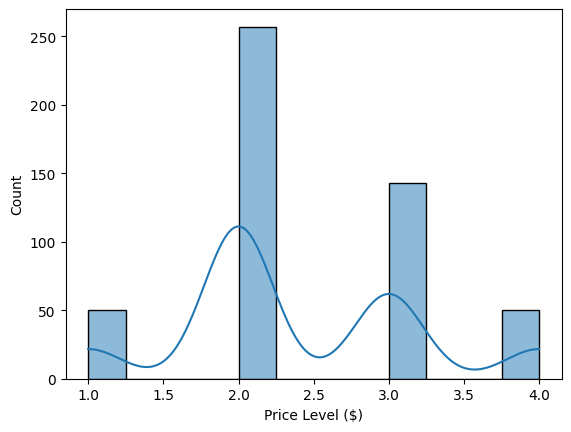

In [45]:
# Let's get a more closer look into the numerical attributes by plotting a histogram
sns.histplot(df["Price Level ($)"], kde = True)
plt.show()

In [46]:
# Let's find the unique categories of the brands
unique_categories = df["Category"].unique()
print(unique_categories)
print(len(unique_categories))

# Let's do the same for Ratings
unique_rating = df["Rating"].unique()
print(unique_rating)
print(len(unique_rating))

# Now Country
unique_country = df["Country"].unique()
print(unique_country)
print(len(unique_country))

# Lastly, Price
unique_price = df["Price Level ($)"].unique()
print(unique_price)
print(len(unique_price))

['Sleepwear' 'Denim' 'Hoodies & Sweatshirts' 'T-Shirts' 'Dresses'
 'Tops & Blouses' 'Shirts' 'Sweaters' 'Jewellery' 'Handbags' 'Activewear'
 'Plus Size' 'Jumpsuits & Playsuits' 'Underwear' 'Satchels & Totes'
 'Sneakers' 'Jackets & Blazers' 'Wallets & Purses' 'Lingerie' 'Swimwear'
 'Pants' 'Hats' 'Belts' 'denim' 'Shorts' 'Stockings & Tights' 'Knitwear'
 'Scarves' 'Hair Accessories' 'Skirts' 'Socks' 'Suits' 'Sandals' 'Watches'
 'Boots' 'Heels' 'Eyewear' 'Backpacks' 'Flats' 'Polos' 'Luggage' 'Casual'
 'Bodysuits' 'Slippers & Comfort' 'Coats' 'tops' 'Dressy']
47
['Great' 'Good' "It's a start" 'Not good enough' 'We avoid']
5
['United States' 'Australia' 'Belgium' 'United Kingdom' 'Netherlands'
 'Germany' 'New Zealand' 'Ireland' 'Eswatini' 'Cambodia' 'Canada' 'Greece'
 'Sweden' 'France' 'Japan' 'Finland' 'Italy' 'South Africa' 'India'
 'Portugal' 'Austria' 'Slovenia' 'Hungary' 'Denmark' 'Hong Kong'
 'Switzerland' 'Spain' 'Ethiopia' 'Sri Lanka' 'Poland' 'Slovakia'
 'Vietnam' 'Colombia' 'Eston

In [47]:
# Let's check for duplicated values
dups = df.duplicated()
print(dups.any())
print(df[dups])

False
Empty DataFrame
Columns: [Brand Name, Rating, Country, Category, Price Level ($)]
Index: []


In [48]:
# Checking for any NA values
df.isna().any()

Brand Name         False
Rating             False
Country            False
Category           False
Price Level ($)    False
dtype: bool

In [49]:
# Let's count the number of unique values in the entire DataFrame
df.nunique()

Brand Name         500
Rating               5
Country             39
Category            47
Price Level ($)      4
dtype: int64

In [50]:
%pip install scikit_learn

Note: you may need to restart the kernel to use updated packages.


In [51]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Define the rating categories in the specified order
ratings_order = ['We avoid', 'Not good enough', "It's a start", 'Good', 'Great']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[ratings_order])

# Apply encoding to the rating column
df['rating_encoded'] = encoder.fit_transform(df[['Rating']]) + 1  # Ensuring 1-based indexing

print(df)
df.to_csv("FinalData.csv", index=False)

# Let's load the data set and have a look at first 5 rows
path = "FinalData.csv"
df = pd.read_csv(path, sep = ",")
df.head()

          Brand Name    Rating         Country               Category  \
0      Boll & Branch     Great   United States              Sleepwear   
1      Outland Denim     Great       Australia                  Denim   
2     STANLEY/STELLA     Great         Belgium  Hoodies & Sweatshirts   
3        Yes Friends     Great  United Kingdom               T-Shirts   
4              ÉTICA     Great   United States                  Denim   
..               ...       ...             ...                    ...   
495       Rirandture  We avoid           Japan         Tops & Blouses   
496       Valleygirl  We avoid       Australia                Dresses   
497           A.P.C.  We avoid          France                 Shirts   
498  BLACK BY MOUSSY  We avoid           Japan         Tops & Blouses   
499           Baleaf  We avoid   United States                  Pants   

     Price Level ($)  rating_encoded  
0                  3             5.0  
1                  2             5.0  
2     

Brand Name Rating         Country               Category  \
0   Boll & Branch  Great   United States              Sleepwear   
1   Outland Denim  Great       Australia                  Denim   
2  STANLEY/STELLA  Great         Belgium  Hoodies & Sweatshirts   
3     Yes Friends  Great  United Kingdom               T-Shirts   
4           ÉTICA  Great   United States                  Denim   

   Price Level ($)  rating_encoded  
0                3             5.0  
1                2             5.0  
2                1             5.0  
3                1             5.0  
4                2             5.0

In [52]:
lexicon = """
**Description for Good On You Dataset after Feature Engineering**

Feature Name       | Description                                           | Units       
------------------|-------------------------------------------------------|------------
Brand Name       | The name of the fashion brand                        | String       
Rating          | Sustainability rating of the brand                   | Categorical ("Great", "Good", "It's a Start", "Not Good Enough", "We Avoid") 
Country         | Country where the brand is based                     | String       
Category        | Type of fashion product (e.g., clothing, accessories) | String       
Price Level ($) | Price rating based on number of black dollar signs   | Integer (1-4) 
rating_encoded  | Numeric encoding of the sustainability rating         | Float (1.0-5.0) 
"""

display(Markdown(lexicon))



**Description for Good On You Dataset after Feature Engineering**

Feature Name       | Description                                           | Units       
------------------|-------------------------------------------------------|------------
Brand Name       | The name of the fashion brand                        | String       
Rating          | Sustainability rating of the brand                   | Categorical ("Great", "Good", "It's a Start", "Not Good Enough", "We Avoid") 
Country         | Country where the brand is based                     | String       
Category        | Type of fashion product (e.g., clothing, accessories) | String       
Price Level ($) | Price rating based on number of black dollar signs   | Integer (1-4) 
rating_encoded  | Numeric encoding of the sustainability rating         | Float (1.0-5.0) 


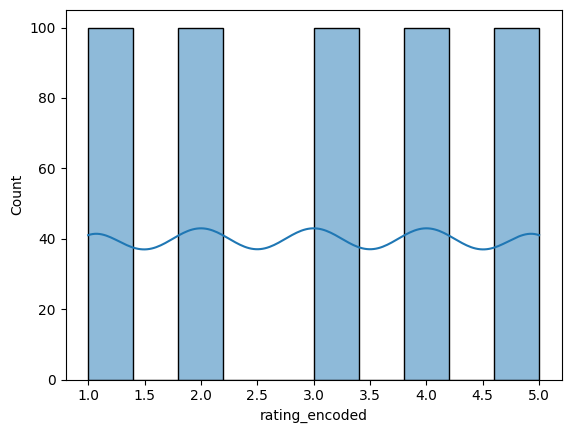

In [53]:
# Let's take a glance at the histogram of rating_encoded
sns.histplot(df["rating_encoded"], kde = True)
plt.show()

Rating Counts:
 rating_encoded
5.0    100
4.0    100
3.0    100
2.0    100
1.0    100
Name: count, dtype: int64


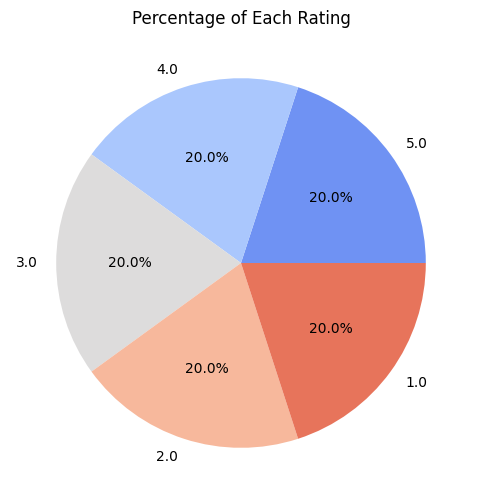

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\3946971321.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["rating_encoded"], palette="coolwarm")


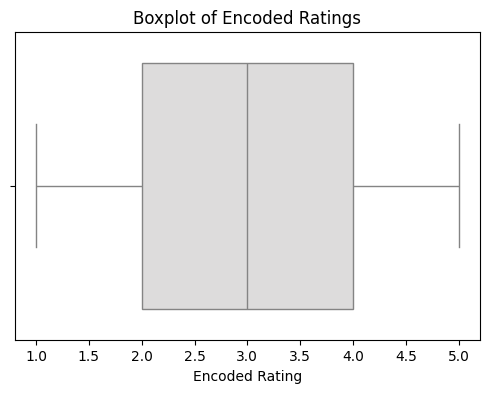

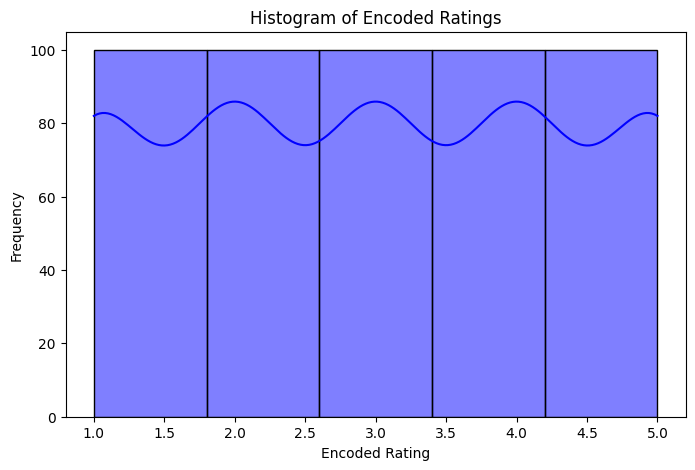

In [54]:
# Count rating occurrences
rating_counts = df["rating_encoded"].value_counts()
print("Rating Counts:\n", rating_counts)

# Pie chart - Rating percentage
plt.figure(figsize=(6,6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(rating_counts)))
plt.title("Percentage of Each Rating")
plt.show()

# Box plot - Distribution of numerical ratings
plt.figure(figsize=(6,4))
sns.boxplot(x=df["rating_encoded"], palette="coolwarm")
plt.xlabel("Encoded Rating")
plt.title("Boxplot of Encoded Ratings")
plt.show()

# Histogram - Distribution of ratings
plt.figure(figsize=(8,5))
sns.histplot(df["rating_encoded"], bins=5, kde=True, color="blue")
plt.xlabel("Encoded Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Encoded Ratings")
plt.show()

Price Level Counts:
 Price Level ($)
2    257
3    143
1     50
4     50
Name: count, dtype: int64


C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\843117303.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_counts.index, y=price_counts.values, palette="viridis")


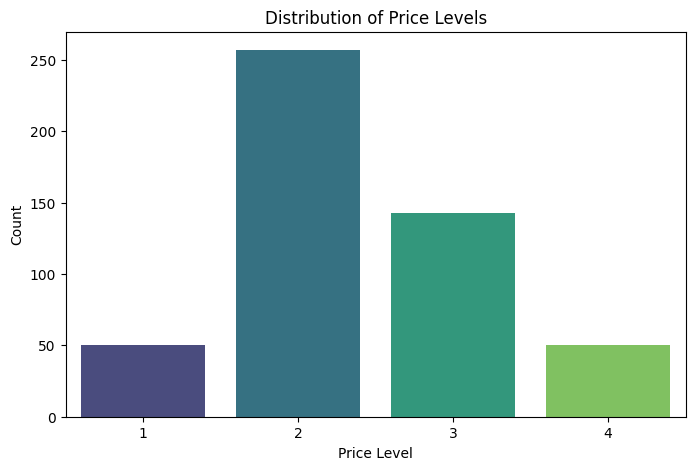

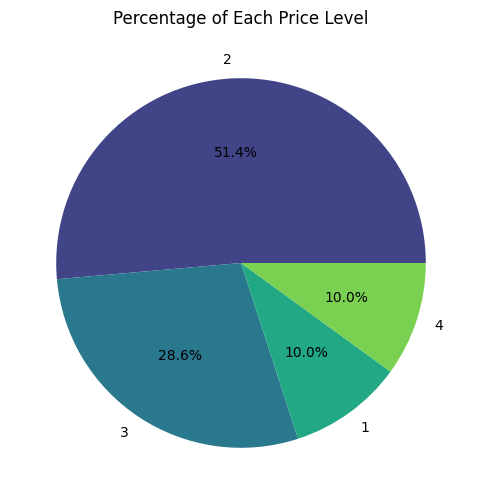

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\843117303.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Price Level ($)"], palette="viridis")


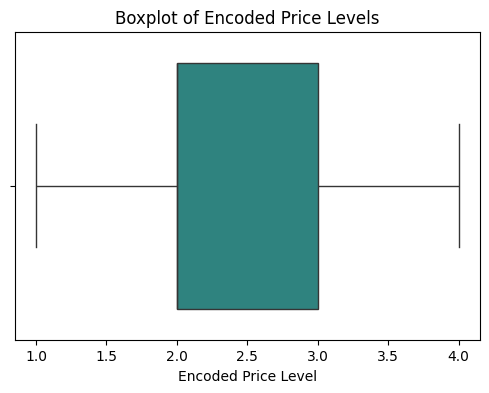

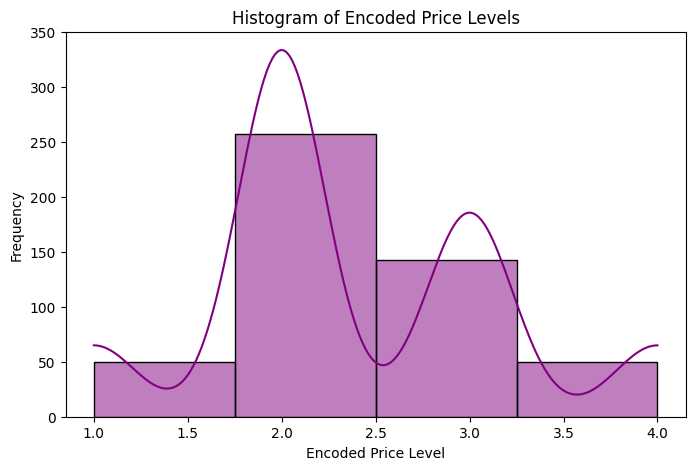

In [55]:
# Count price level occurrences
price_counts = df["Price Level ($)"].value_counts()
print("Price Level Counts:\n", price_counts)

# Bar plot - Distribution of price levels
plt.figure(figsize=(8,5))
sns.barplot(x=price_counts.index, y=price_counts.values, palette="viridis")
plt.xlabel("Price Level")
plt.ylabel("Count")
plt.title("Distribution of Price Levels")
plt.show()

# Pie chart - Percentage of each price level
plt.figure(figsize=(6,6))
plt.pie(price_counts, labels=price_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(price_counts)))
plt.title("Percentage of Each Price Level")
plt.show()

# Box plot - Distribution of numerical price levels
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Price Level ($)"], palette="viridis")
plt.xlabel("Encoded Price Level")
plt.title("Boxplot of Encoded Price Levels")
plt.show()

# Histogram - Distribution of price levels
plt.figure(figsize=(8,5))
sns.histplot(df["Price Level ($)"], bins=4, kde=True, color="purple")
plt.xlabel("Encoded Price Level")
plt.ylabel("Frequency")
plt.title("Histogram of Encoded Price Levels")
plt.show()

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\1734847904.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")


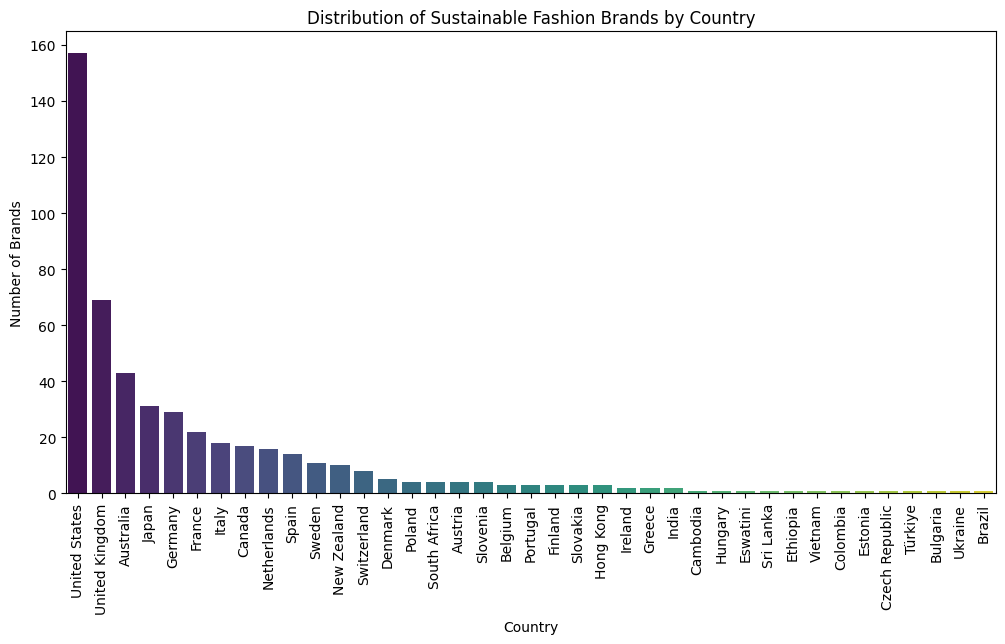

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\1734847904.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=country_counts.index, x=country_counts.values, palette="coolwarm")


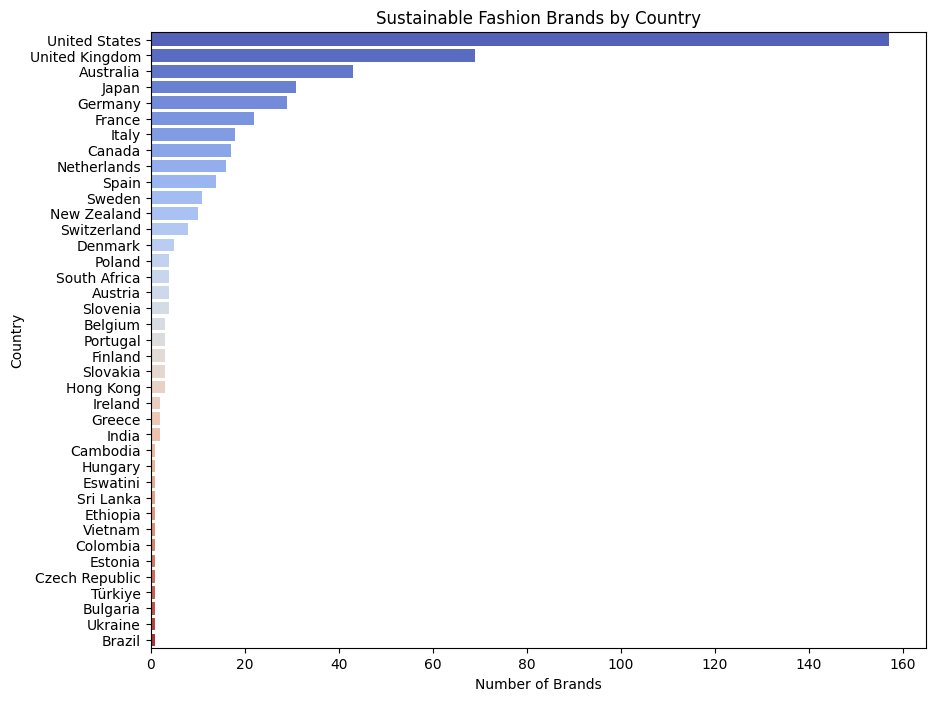

In [56]:
# Count the number of brands per country
country_counts = df["Country"].value_counts()

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Number of Brands")
plt.title("Distribution of Sustainable Fashion Brands by Country")
plt.show()

# Horizontal Bar Chart (for better readability)
plt.figure(figsize=(10, 8))
sns.barplot(y=country_counts.index, x=country_counts.values, palette="coolwarm")
plt.xlabel("Number of Brands")
plt.ylabel("Country")
plt.title("Sustainable Fashion Brands by Country")
plt.show()

In [57]:
%pip install plotly geopandas
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.



In [58]:
# Choropleth Map (Brands by Country)
# Instead of a bar chart, you can create a world map where each country 
# is colored based on the number of brands. This gives a global perspective.

# Count number of brands per country
country_counts = df.groupby("Country").size().reset_index(name="brand_count")

import plotly.express as px
import nbformat

# Plot Choropleth map
fig = px.choropleth(
    country_counts,
    locations="Country",
    locationmode="country names",
    color="brand_count",
    color_continuous_scale="Viridis",
    title="Sustainable Fashion Brands Distribution by Country",
)

fig.show()


C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\2326337783.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




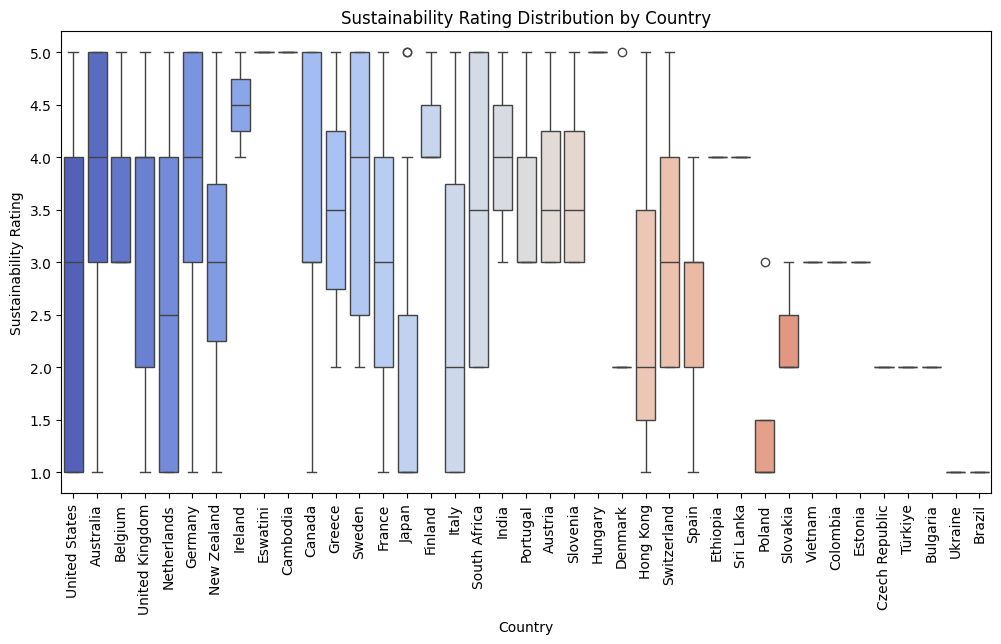

In [59]:
# Relationship Between Country & Sustainability Rating
# Let's find whether some countries have more sustainable brands than others.
# Approach: Boxplot of brand sustainability ratings by country.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Country", y="rating_encoded", palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Sustainability Rating")
plt.title("Sustainability Rating Distribution by Country")
plt.show()

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\2975101164.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




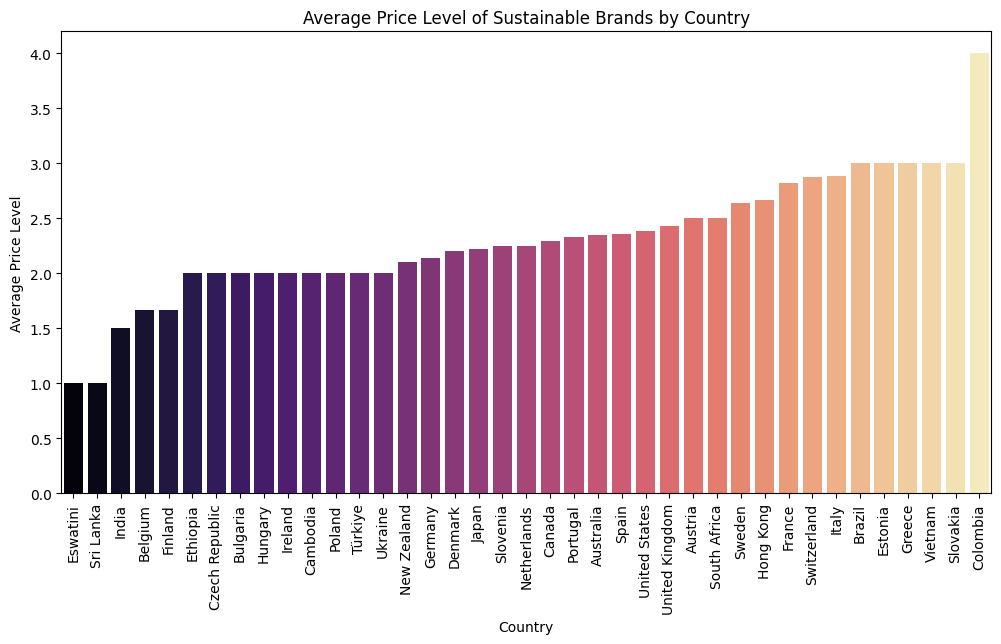

In [60]:
# Average Price Level Per Country
# Some countries might have more expensive sustainable brands than others.
# Approach: Bar chart of average price level per country.
# Helps understand whether sustainability is affordable in certain regions.

avg_price_by_country = df.groupby("Country")["Price Level ($)"].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_by_country.index, y=avg_price_by_country.values, palette="magma")
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Average Price Level")
plt.title("Average Price Level of Sustainable Brands by Country")
plt.show()

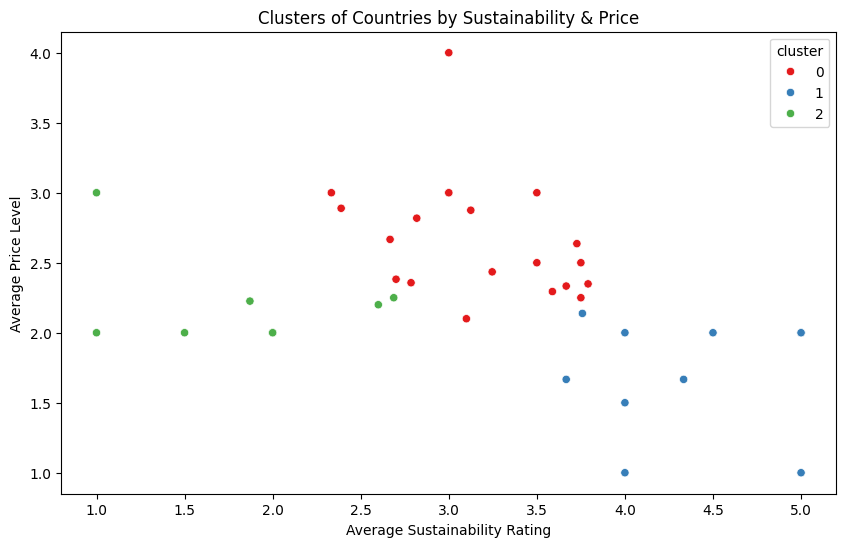

In [61]:
# Cluster Analysis of Countries (Advanced)
# Using K-Means clustering to group countries based on rating & price levels and see if trends emerge.
# Identifies patterns—e.g., do some countries have high sustainability ratings but expensive brands?

# Aggregate by country
country_data = df.groupby("Country").agg({"rating_encoded": "mean", "Price Level ($)": "mean"}).dropna()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(country_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
country_data["cluster"] = kmeans.fit_predict(scaled_data)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=country_data["rating_encoded"],
    y=country_data["Price Level ($)"],
    hue=country_data["cluster"],
    palette="Set1",
)
plt.xlabel("Average Sustainability Rating")
plt.ylabel("Average Price Level")
plt.title("Clusters of Countries by Sustainability & Price")
plt.show()


C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\3395456293.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




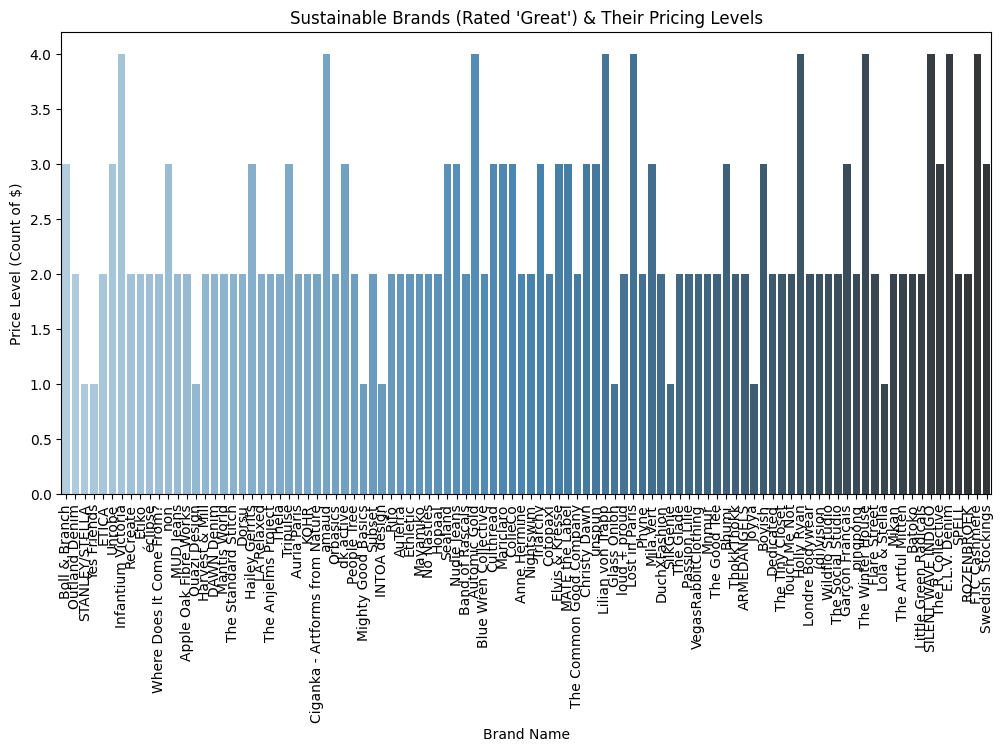

In [62]:
# Visualizing brands with great rating and with price levels

# Filter only brands rated "Great"
great_brands = df[df["Rating"] == "Great"]

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=great_brands, x="Brand Name", y="Price Level ($)", palette="Blues_d")

# Customize the plot
plt.xticks(rotation=90)  # Rotate brand names for readability
plt.xlabel("Brand Name")
plt.ylabel("Price Level (Count of $)")
plt.title("Sustainable Brands (Rated 'Great') & Their Pricing Levels")

# Show the plot
plt.show()

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\2045494151.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




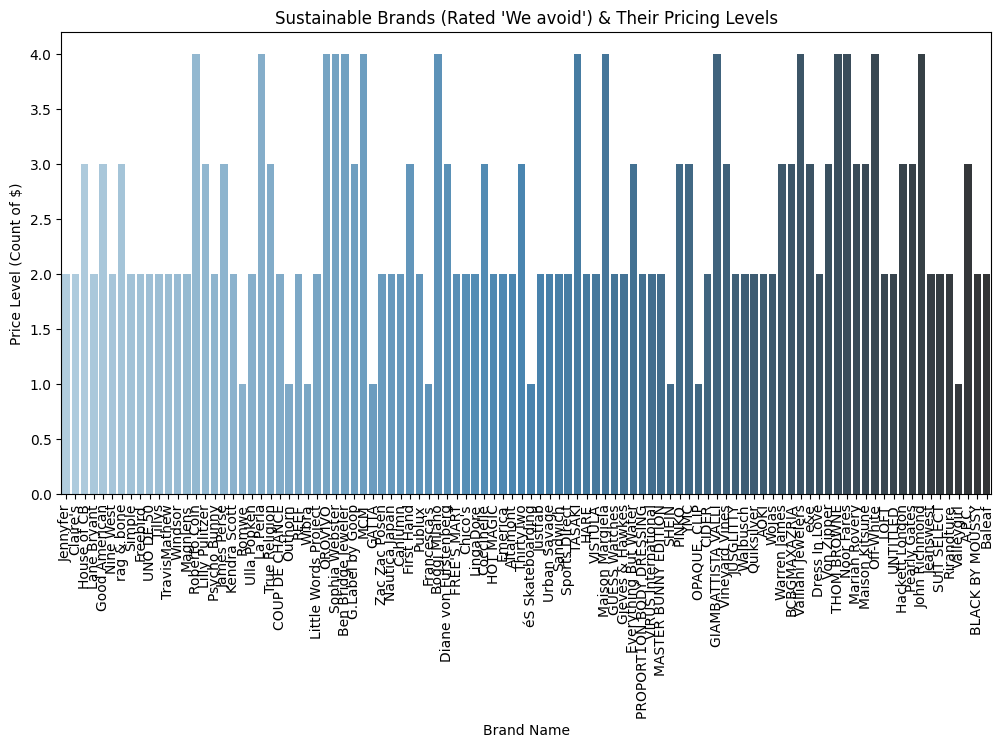

In [63]:
# Visualizing brands with great rating and with price levels

# Filter only brands rated "Great"
weAvoid_brands = df[df["Rating"] == "We avoid"]

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=weAvoid_brands, x="Brand Name", y="Price Level ($)", palette="Blues_d")

# Customize the plot
plt.xticks(rotation=90)  # Rotate brand names for readability
plt.xlabel("Brand Name")
plt.ylabel("Price Level (Count of $)")
plt.title("Sustainable Brands (Rated 'We avoid') & Their Pricing Levels")

# Show the plot
plt.show()

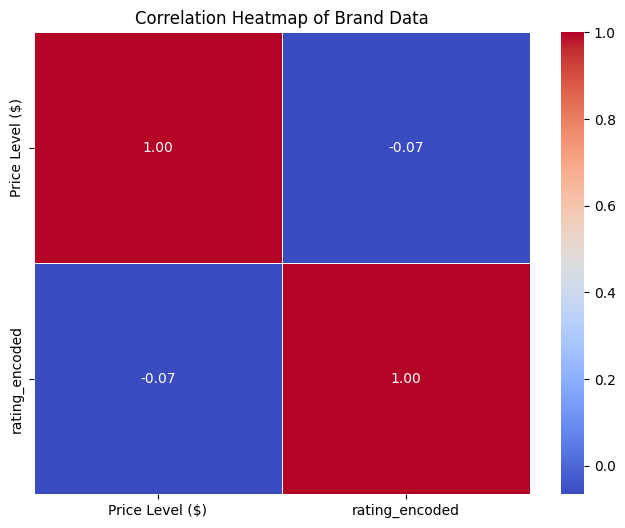

In [64]:
# Drop non-numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Customize plot
plt.title("Correlation Heatmap of Brand Data")
plt.show()

In [65]:
# We have chosen 6 random brands, 3 Fast Fashion and 3 Sustainable Brands. Let's start extracting products from each brand.

In [66]:
#final  code for  h&M
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Setup WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Open H&M category page
category_url = "https://www2.hm.com/en_gb/ladies/new-arrivals/view-all.html"  
driver.get(category_url)

# Accept cookies if prompted
try:
    cookie_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept')]"))
    )
    cookie_button.click()
    print("✅ Cookie pop-up accepted.")
except:
    print("⚠ No cookie pop-up found.")

# Wait for products to load
time.sleep(3)

# Extract 20 **unique** product links
product_links = []
try:
    while len(product_links) < 20:
        product_elements = driver.find_elements(By.XPATH, "//article[contains(@data-articlecode, '')]//a[@href]")
        
        for product in product_elements:
            link = product.get_attribute("href")
            if link not in product_links:
                product_links.append(link)
            if len(product_links) == 20:  # Stop after getting 20 unique links
                break
        
        # Scroll down to load more products if needed
        driver.find_element(By.TAG_NAME, "body").send_keys(Keys.PAGE_DOWN)
        time.sleep(2)

except:
    print("❌ Unable to find product links.")

print(f"✅ Found {len(product_links)} product links.")

# Store extracted data
data = []

# Loop through each product link
for index, link in enumerate(product_links, start=1):
    driver.get(link)
    time.sleep(2)  # Allow page to load

    # Extract product details
    try:
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        # Extract product name
        product_name = soup.find("h1").text.strip() if soup.find("h1") else "Not Found"

        # Extract price
        price_element = soup.find("span", class_="edbe20")  # Adjust class if needed
        product_price = price_element.text.strip() if price_element else "Not Found"

        # Scroll down to make the 'Materials' section visible
        actions = ActionChains(driver)
        actions.send_keys(Keys.PAGE_DOWN).perform()
        time.sleep(2)

        # Click 'Materials & Composition' section if available
        try:
            materials_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@aria-controls, 'section-materialsAndSuppliersAccordion')]"))
            )
            driver.execute_script("arguments[0].click();", materials_button)
            time.sleep(2)
            print(f"✅ Clicked on 'Materials & Composition' section for product {index}.")
        except:
            print(f"⚠ No 'Materials & Composition' section found for product {index}.")

        # Wait for materials section to be visible
        time.sleep(2)

        # Extract material composition
        try:
            materials_div = driver.find_element(By.XPATH, "//div[@id='section-materialsAndSuppliersAccordion']")
            raw_materials_text = materials_div.text.strip()

            # **Extract only fabric composition values (percentages + materials)**
            fabric_matches = re.findall(r'([A-Za-z]+\s\d+%|\d+%\s[A-Za-z]+)', raw_materials_text)
            materials_text = ", ".join(fabric_matches) if fabric_matches else "Not Found"

        except:
            materials_text = "Not Found"

        # Append data
        data.append({
            "Product Name": product_name,
            "Price": product_price,
            "Material Composition": materials_text
        })
        print(f"✅ Extracted product {index}: {product_name}")

    except Exception as e:
        print(f"❌ Error extracting product {index}:", e)

    # Navigate back to category page
    driver.back()
    time.sleep(2)

# Close WebDriver
driver.quit()

# Save data to CSV
df_hm = pd.DataFrame(data)
df_hm.to_csv("HM.csv", index=False)
print("\n✅ Data saved to 'HM.csv'\n")
df_hm


✅ Cookie pop-up accepted.
✅ Found 20 product links.
✅ Clicked on 'Materials & Composition' section for product 1.
✅ Extracted product 1: Cropped T-shirt
⚠ No 'Materials & Composition' section found for product 2.
✅ Extracted product 2: Women's Short Sleeve Tops
✅ Clicked on 'Materials & Composition' section for product 3.
✅ Extracted product 3: Button-front vest top
✅ Clicked on 'Materials & Composition' section for product 4.
✅ Extracted product 4: Button-front vest top
✅ Clicked on 'Materials & Composition' section for product 5.
✅ Extracted product 5: Cotton midi skirt
⚠ No 'Materials & Composition' section found for product 6.
✅ Extracted product 6: High-Waisted Skirts
✅ Clicked on 'Materials & Composition' section for product 7.
✅ Extracted product 7: Wide twill trousers
✅ Clicked on 'Materials & Composition' section for product 8.
✅ Extracted product 8: Wide twill trousers
✅ Clicked on 'Materials & Composition' section for product 9.
✅ Extracted product 9: Wide twill trousers
✅ C

Product Name      Price  \
0             Cropped T-shirt     £12.99   
1   Women's Short Sleeve Tops  Not Found   
2       Button-front vest top     £27.99   
3       Button-front vest top     £27.99   
4           Cotton midi skirt     £22.99   
5         High-Waisted Skirts  Not Found   
6         Wide twill trousers     £24.99   
7         Wide twill trousers     £24.99   
8         Wide twill trousers     £24.99   
9          Fine-knit cardigan     £37.99   
10               Poplin shirt     £22.99   
11             Twill car coat     £44.99   
12             Twill car coat     £44.99   
13    Belted bubble-hem dress     £32.99   
14    Belted bubble-hem dress     £32.99   
15           Fine-knit shorts     £27.99   
16     Single-breasted blazer     £37.99   
17     Single-breasted blazer     £37.99   
18    Broderie anglaise dress     £44.99   
19             Suit waistcoat     £27.99   

                                 Material Composition  
0                           Cotton 100%, 20% Recycled  
1                                           Not Found  
2           Viscose 55%, Polyester 23%, Polyamide 22%  
3           Viscose 55%, Polyester 23%, Polyamide 22%  
4                           Cotton 100%, 20% Recycled  
5                                           Not Found  
6   Viscose 91%, Polyester 9%, Polyester 100%, 85%...  
7   Viscose 91%, Polyester 9%, Polyester 100%, 85%...  
8   Viscose 91%, Polyester 9%, Polyester 100%, 85%...  
9   Viscose 55%, Polyester 23%, Polyamide 22%, 55%...  
10                                        Cotton 100%  
11  Cotton 63%, Polyamide 37%, Polyester 100%, 23%...  
12  Cotton 63%, Polyamide 37%, Polyester 100%, 23%...  
13                           Cotton 100%, Cotton 100%  
14                           Cotton 100%, Cotton 100%  
15  Viscose 55%, Polyester 23%, Polyamide 22%, 55%...  
16  Polyester 68%, Viscose 32%, Polyester 100%, 25...  
17  Polyester 69%, Viscose 31%, Polyester 100%, 55...  
18            Viscose 75%, Polyamide 25%, 75% LENZING  
19  Viscose 92%, Polyester 8%, Polyester 100%, 76%...

In [67]:
# Setup WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Open Primark category page
category_url = "https://www.primark.com/en-gb/r/women/new-arrivals/clothing"  # Example category page
driver.get(category_url)

# Accept cookies if pop-up appears
try:
    cookie_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept')]"))
    )
    cookie_button.click()
    print("✅ Cookie pop-up accepted.")
except:
    print("⚠ No cookie pop-up found.")

# Wait for product elements to load
time.sleep(3)

# Extract product links (20 unique products)
product_links = set()
products_needed = 20

while len(product_links) < products_needed:
    try:
        product_elements = driver.find_elements(By.XPATH, "//a[contains(@href, '/en-gb/p/')]")
        for product in product_elements:
            link = product.get_attribute("href")
            if link not in product_links:
                product_links.add(link)
            if len(product_links) >= products_needed:  # Stop after getting 20 unique links
                break
    except:
        print("❌ Unable to find more product links.")
        break

    # Click "Load More" **ONLY WHEN** we reach 24 products and need more
    if len(product_links) == 24:
        try:
            load_more_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Load More')]"))
            )
            driver.execute_script("arguments[0].click();", load_more_button)
            time.sleep(5)  # Allow more products to load
            print("✅ Clicked 'Load More' to fetch additional products.")
        except:
            print("⚠ 'Load More' button not found or already loaded all products.")
            break  # Exit loop if more products cannot be loaded

print(f"✅ Found {len(product_links)} product links.")

# Store extracted data
data = []

# Visit each product link
for index, link in enumerate(product_links):
    driver.get(link)
    time.sleep(3)  # Allow page to load

    try:
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Extract product name
        product_name = soup.find("h1").text.strip() if soup.find("h1") else "Not Found"

        # Extract price
        price_element = soup.find("p", {"data-testautomation-id": "product-price"})
        product_price = price_element.text.strip() if price_element else "Not Found"

        # Scroll down to make the 'Description' section visible
        actions = ActionChains(driver)
        actions.send_keys(Keys.PAGE_DOWN).perform()
        time.sleep(2)

        # Click 'Description' section if available
        try:
            description_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//p[contains(text(), 'Description')]"))
            )
            driver.execute_script("arguments[0].click();", description_button)
            time.sleep(3)
            print(f"✅ Clicked on 'Description' section for product {index + 1}.")
        except:
            print(f"⚠ No 'Description' section found for product {index + 1}.")

        # Wait and extract material composition
        time.sleep(3)

        try:
            # Locate the parent element of the description section
            description_section = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, "//div[contains(@class, 'MuiAccordionDetails-root')]"))
            )

            # Extract all text in the description section
            description_text = description_section.text.strip()

            # Find only the "Material Composition" line
            material_composition = "Not Found"
            for line in description_text.split("\n"):
                if "Material Composition" in line:
                    material_composition = line.replace("Material Composition: ", "").strip()
                    break  # Stop after finding the relevant information

        except:
            material_composition = "Not Found"

        # Append data
        data.append({
            "Product Name": product_name,
            "Price": product_price,
            "Material Composition": material_composition
        })

    except Exception as e:
        print(f"❌ Error extracting product {index + 1} details:", e)

# Close WebDriver
driver.quit()

# Save data to CSV
df_primark = pd.DataFrame(data)
df_primark.to_csv("Primark.csv", index=False)
print("\n✅ Data saved to 'Primark.csv'\n")
df_primark


✅ Cookie pop-up accepted.
✅ Found 20 product links.
✅ Clicked on 'Description' section for product 1.
✅ Clicked on 'Description' section for product 2.
✅ Clicked on 'Description' section for product 3.
✅ Clicked on 'Description' section for product 4.
✅ Clicked on 'Description' section for product 5.
✅ Clicked on 'Description' section for product 6.
✅ Clicked on 'Description' section for product 7.
✅ Clicked on 'Description' section for product 8.
✅ Clicked on 'Description' section for product 9.
✅ Clicked on 'Description' section for product 10.
✅ Clicked on 'Description' section for product 11.
✅ Clicked on 'Description' section for product 12.
✅ Clicked on 'Description' section for product 13.
✅ Clicked on 'Description' section for product 14.
✅ Clicked on 'Description' section for product 15.
✅ Clicked on 'Description' section for product 16.
✅ Clicked on 'Description' section for product 17.
✅ Clicked on 'Description' section for product 18.
✅ Clicked on 'Description' section for 

Product Name   Price         Material Composition
0         Oversized Short Sleeve T-shirt   £7.00                  100% Cotton
1                 Oversized Boxy T-Shirt   £5.00                  100% Cotton
2   The Edit Satin Straight Leg Trousers  £24.00    83% Viscose 17% Polyamide
3                       Boxy Fit T-Shirt   £5.00                  100% Cotton
4     Oversized Essential Jersey T-Shirt   £7.00                  100% Cotton
5              Ribbed Racerback Vest Top   £5.00     95% Cotton,  5% Elastane
6                       Boxy Fit T-Shirt   £5.00                  100% Cotton
7               Bride Graphic Sweatshirt  £13.00     60% Polyester 40% Cotton
8   Kappa x Primark Seamless Yoga Shorts  £11.00      95% Nylon,  5% Elastane
9                 Oversized Boxy T-Shirt   £5.00                  100% Cotton
10                    Pleated Mini Skirt  £14.00               100% Polyester
11                Oversized Boxy T-Shirt   £5.00                  100% Cotton
12             Drawstring Beach Trousers  £10.00                  100% Cotton
13    Kappa x Primark Cropped Sweatshirt  £18.00                    Not Found
14    Oversized Essential Jersey T-Shirt   £7.00                  100% Cotton
15             Pull On Wide Leg Trousers  £10.00               100% Polyester
16                 Crew Neck Gym T-shirt   £4.50  87% Polyester, 13% Elastane
17                Tailored Slim Trousers   £7.00               Polyester 100%
18              Long Sleeve Skater Dress   £8.00  90% Polyester, 10% Elastane
19     Kappa x Primark Seamless Crop Top  £12.00       95% Nylon, 5% Elastane

In [68]:
#final code for allsaints data

# Setup WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features=AutomationControlled")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Open AllSaints New Arrivals Page
category_url = "https://www.allsaints.com/women/new"
driver.get(category_url)

# Wait for page to load
time.sleep(5)

# Extract first 20 product links
product_links = []
try:
    product_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.XPATH, "//a[contains(@class, 'b-product_tile-image_link')]"))
    )
    product_links = [elem.get_attribute("href") for elem in product_elements[:20]]
    print(f"✅ Found {len(product_links)} product links.")
except:
    print("❌ Unable to find product links.")

# Store extracted data
data = []

# Function to clean material composition
def clean_material_text(text):
    # Extract only the percentage and material type
    matches = re.findall(r"(\d+% [a-zA-Z\s]+)", text)
    return ", ".join(matches) if matches else "Not Found"

# Loop through each product link
for index, link in enumerate(product_links, start=1):
    driver.get(link)
    time.sleep(5)  # Allow page to load

    try:
        # Extract Product Name
        product_name = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//h1[@data-tau='product_details_name']"))
        ).text.strip()

        # Extract Price
        try:
            product_price = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//span[contains(@class, 'b-price-item')]"))
            ).text.strip()
        except:
            product_price = "Price Not Found"

        # Click the "Details" tab to reveal material composition
        try:
            details_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "//button[@id='button-description']"))
            )
            driver.execute_script("arguments[0].click();", details_button)
            time.sleep(2)
        except:
            print(f"⚠ No 'Details' button found for product {index}.")

        # Extract Material Composition from the list inside Details tab
        try:
            material_elements = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.XPATH, "//div[contains(@class, 'b-pdp_user_content')]//li"))
            )
            material_texts = [elem.text for elem in material_elements if "%" in elem.text]
            material_composition = clean_material_text(" ".join(material_texts))
        except:
            material_composition = "Not Found"

        # Append data to list
        data.append({
            "Product Name": product_name,
            "Price": product_price,
            "Material Composition": material_composition
        })

        print(f"✅ Extracted Product {index}: {product_name} - Material: {material_composition}")

    except Exception as e:
        print(f"❌ Error extracting product {index}: {e}")

# Close WebDriver
driver.quit()

# Convert data to DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_filename = "AllSaints.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")

# Display DataFrame
print("\n✅ Extracted Data:")
print(df)

print(f"\n✅ Data saved to '{csv_filename}'")


✅ Found 20 product links.
✅ Extracted Product 1: Lala Floral Maxi Dress - Material: 95% polyester, 5% elastane, 100% recycled polyester Lining, 100% recycled polyester
✅ Extracted Product 2: Marlene Fringed Denim Jacket - Material: 50% organic cotton, 50% cotton 
✅ Extracted Product 3: Sofi Drawstring Leather Bomber Jacket - Material: 100% sheep leather Rib, 97% organic cotton, 3% elastane Lining, 100% recycled polyester
✅ Extracted Product 4: Anthe Wool Ribbed Jumper - Material: 100% wool
✅ Extracted Product 5: Lizi Tiered Lace Maxi Skirt - Material: 100% recycled polyester
✅ Extracted Product 6: Bryony Maxi Slip Dress - Material: 100% recycled polyester
✅ Extracted Product 7: Ali Logo Canvas Tote Bag - Material: 100% cotton
✅ Extracted Product 8: Heather Long Sleeve Lace Trimmed Top - Material: 100% ramie lace Trim, 100% cotton
✅ Extracted Product 9: Julieana V Neck Wrap Jumper - Material: 100% merino wool
✅ Extracted Product 10: Odyssey Low Boot - Material: 100% cow leather Lining, 

In [69]:
#final code for people tree data
from selenium.webdriver.chrome.options import Options

# Setup Chrome options
chrome_options = Options()
chrome_options.add_argument("--disable-popup-blocking")  # Disable popups
chrome_options.add_argument("--start-maximized")  # Open in full screen
# chrome_options.add_argument("--headless")  # Run in headless mode (Remove if you want to see the browser)

# Automatically install and manage ChromeDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

try:
    # Step 1: Open the main website page
    main_url = "https://peopletree.eu/collections/latest-arrivals"
    driver.get(main_url)
    time.sleep(3)  # Wait for page to load

    # Step 2: Handle Cookie Pop-up (If Exists)
    try:
        cookie_button = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept')]"))
        )
        cookie_button.click()
        print("Cookie popup closed.")
        time.sleep(2)
    except:
        print("No cookie popup found.")

    # Step 3: Get the first 20 product links
    product_elements = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.product-link.is-not-relative"))
    )

    product_links = [element.get_attribute("href") for element in product_elements[:20]]  # Get URLs of first 20 products
    print(f"Found {len(product_links)} product links.")

    # List to store extracted data
    product_data = []

    # Step 4: Loop through each product page
    for index, product_url in enumerate(product_links):
        print(f"\nScraping Product {index+1}: {product_url}")
        driver.get(product_url)
        time.sleep(3)  # Wait for page to load

        # Extract product name
        product_name = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "product__title"))
        ).text

        # Extract price
        price = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "product__price"))
        ).text

        # Scroll to Composition Section
        composition_tab = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//p[contains(text(), 'Composition')]"))
        )
        driver.execute_script("arguments[0].scrollIntoView();", composition_tab)
        time.sleep(2)

        # Click to expand Composition Section using JavaScript
        driver.execute_script("arguments[0].click();", composition_tab)
        time.sleep(2)

        # Wait for Composition Content to Load
        try:
            composition_content = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//div[contains(@class, 'rte accordion-content')]/p"))
            ).text
        except:
            composition_content = "Composition not found"

        # Append data to list
        product_data.append({
            "Product Name": product_name,
            "Price": price,
            "Composition": composition_content
        })

    # Step 5: Store data in a Pandas DataFrame
    df = pd.DataFrame(product_data)

    # Save the DataFrame as a CSV file
    csv_filename = "people_tree.csv"
    df.to_csv(csv_filename, index=False, encoding="utf-8")
    print(f"\nCSV file saved: {csv_filename}")

    # Print the DataFrame
    print("\nExtracted Product Details:")
    print(df)

except Exception as e:
    print("Error:", e)

finally:
    driver.quit()  # Close the browser


Cookie popup closed.
Found 20 product links.

Scraping Product 1: https://peopletree.eu/collections/latest-arrivals/products/leora-wrap-dress-in-red

Scraping Product 2: https://peopletree.eu/collections/latest-arrivals/products/leora-wrap-dress-in-blue

Scraping Product 3: https://peopletree.eu/collections/latest-arrivals/products/leora-wrap-dress-in-black

Scraping Product 4: https://peopletree.eu/collections/latest-arrivals/products/jayne-slub-tee-in-blue

Scraping Product 5: https://peopletree.eu/collections/latest-arrivals/products/evelyn-jumpsuit-in-dark-grey

Scraping Product 6: https://peopletree.eu/collections/latest-arrivals/products/sasha-trousers-in-dark-grey

Scraping Product 7: https://peopletree.eu/collections/latest-arrivals/products/leggings-in-dark-grey

Scraping Product 8: https://peopletree.eu/collections/latest-arrivals/products/jacinta-trousers-in-navy

Scraping Product 9: https://peopletree.eu/collections/latest-arrivals/products/jacinta-trousers-in-black

Scrapi

In [70]:
#final code kohr fashion data

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode
chrome_options.add_argument("--disable-popup-blocking")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Set up WebDriver with automatic driver installation
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# Open Kohr Fashion main product listing page
main_url = "https://www.kohrfashion.com/collections/all"
driver.get(main_url)
time.sleep(5)  # Wait for the page to load

# Extract product links (at least 20, navigating to the next page if necessary)
product_links = set()
current_page = 1

while len(product_links) < 20:
    try:
        products = driver.find_elements(By.XPATH, "//a[contains(@href, '/collections/all/products/')]")
        for product in products:
            link = product.get_attribute("href")
            if link and link not in product_links:
                product_links.add(link)

            # Stop when we have enough links
            if len(product_links) >= 20:
                break
    except Exception as e:
        print("Error: Could not fetch product links.", e)

    # Check if there are more pages
    if len(product_links) >= 12 and len(product_links) < 20:
        try:
            next_page_xpath = f"//a[@href='/collections/all?page={current_page + 1}']"
            next_button = driver.find_element(By.XPATH, next_page_xpath)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)  # Wait for new products to load
            current_page += 1  # Increment page number
        except:
            print("No next page button found or all products are loaded.")
            break  # Stop if no more pages are available

# Convert set to list and keep only the first 20 links
product_links = list(product_links)[:20]

# Initialize list to store product data
products_data = []

# Loop through each product link and extract details
for index, product_url in enumerate(product_links):
    print(f"Scraping product {index + 1}: {product_url}")
    driver.get(product_url)
    time.sleep(5)  # Allow time for page load

    # Extract Product Name
    try:
        product_name = driver.find_element(By.XPATH, "//h1[contains(@class, 'product__title')]").text
    except Exception:
        product_name = "Product name not found"

    # Extract Price
    try:
        price = driver.find_element(By.XPATH, "//div[contains(@class, 'product__price')]//span[@data-product-price]").text
        if not price:
            price = driver.find_element(By.XPATH, "//div[contains(@class, 'product__price')]//span").text  # Alternative method
    except Exception:
        price = "Price not found"

    # Extract Material Information
    try:
        # Scroll to materials section
        materials_button = driver.find_element(By.XPATH, "//button[contains(text(), 'Materials')]")
        driver.execute_script("arguments[0].scrollIntoView(true);", materials_button)
        time.sleep(1)

        # Click only if needed
        if materials_button.is_displayed():
            driver.execute_script("arguments[0].click();", materials_button)
            time.sleep(3)  # Wait for the section to expand

        # Try different XPaths for the materials section
        try:
            materials = driver.find_element(By.XPATH, "//div[contains(@class, 'metafield-rich_text_field')]//p").text
        except:
            materials = driver.find_element(By.XPATH, "//div[contains(@class, 'accordion__text')]").text
    except Exception:
        materials = "Materials not found"

    # Append extracted data to list
    products_data.append({"Product Name": product_name, "Price": price, "Materials": materials})

# Convert data to Pandas DataFrame
df = pd.DataFrame(products_data)

# Save to CSV
df.to_csv("kohr.csv", index=False)

# Display extracted data
print("\n--- Extracted Product Data ---")
print(df)

# Close the browser
driver.quit()


Scraping product 1: https://www.kohrfashion.com/collections/all/products/fine-rib-racer-dress
Scraping product 2: https://www.kohrfashion.com/collections/all/products/1-21-hoodie
Scraping product 3: https://www.kohrfashion.com/collections/all/products/natural-raw-box-tee
Scraping product 4: https://www.kohrfashion.com/collections/all/products/multi-purpose-waffle-bag
Scraping product 5: https://www.kohrfashion.com/collections/all/products/kohr-gift-card
Scraping product 6: https://www.kohrfashion.com/collections/all/products/1-3-regular-tee
Scraping product 7: https://www.kohrfashion.com/collections/all/products/oversized-tee
Scraping product 8: https://www.kohrfashion.com/collections/all/products/1-41-sweatshirt
Scraping product 9: https://www.kohrfashion.com/collections/all/products/joggers-1
Scraping product 10: https://www.kohrfashion.com/collections/all/products/fine-rib-racer-top
Scraping product 11: https://www.kohrfashion.com/collections/all/products/heavyweight-racer-top
Scrap

In [71]:
#final code for outland denim data
import random
import csv

# Base URL of the website
main_url = "https://outlanddenim.com/collections/womens-new-arrivals"
base_url = "https://outlanddenim.com"

# User-Agent header to mimic a real browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Send request to fetch the main product listing page
response = requests.get(main_url, headers=headers)

# List to store product links
product_links = []

if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all product links on the main page
    product_elements = soup.select("li.column a")  # Adjust the selector if needed

    for product in product_elements:
        href = product.get("href")
        if href and "/products/" in href:
            full_url = base_url + href
            product_links.append(full_url)

else:
    print(f"Failed to retrieve the main page. Status code: {response.status_code}")

# Limit to first 20 products (adjust as needed)
product_links = product_links[:20]

# Predefined materials options (randomly assigned)
materials_options = ["100% Regenerative Cotton", "100% Organic Cotton"]

# List to store scraped data
scraped_data = []

# Scrape each product page
for url in product_links:
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract product name
        product_name = soup.find("h1").text.strip() if soup.find("h1") else "N/A"

        # Extract product price
        price_element = soup.find("span", class_="amount")
        product_price = price_element.text.strip() if price_element else "N/A"

        # Assign a random material since scraping it dynamically isn't working
        product_material = random.choice(materials_options)

        # Store the data
        scraped_data.append([product_name, product_price, product_material])

        print(f"Scraped: {product_name} - {product_price} - {product_material}")

    else:
        print(f"Failed to retrieve {url}. Status code: {response.status_code}")

# Save the data to a CSV file
csv_filename = "outland_denim.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Product Name", "Price", "Materials"])
    writer.writerows(scraped_data)

print(f"\n✅ Scraping complete! Data saved to {csv_filename}")


Scraped: CANVS x Outland Denim Utility Overall - $485 - 100% Regenerative Cotton
Scraped: CANVS x Outland Denim Utility Overall - $485 - 100% Regenerative Cotton
Scraped: Mia Buttoned Mid Wide Long Jean Opulent Blue - $289 - 100% Organic Cotton
Scraped: Mia Buttoned Mid Wide Long Jean Opulent Blue - $289 - 100% Organic Cotton
Scraped: Annie High Classic Short Serenity - $185 - 100% Organic Cotton
Scraped: Annie High Classic Short Serenity - $185 - 100% Regenerative Cotton
Scraped: Annie High Classic Short Aged Black - $175.00 - 100% Regenerative Cotton
Scraped: Annie High Classic Short Former - $175.00 - 100% Regenerative Cotton
Scraped: Annie High Classic Short Soft White - $175.00 - 100% Regenerative Cotton
Scraped: Iris LS Shirt - $349 - 100% Regenerative Cotton
Scraped: Iris LS Shirt - $349 - 100% Regenerative Cotton
Scraped: Iris LS Shirt - $359 - 100% Organic Cotton
Scraped: Mia Cuffed Mid Wide Long Jean Meridian Mid Blue - $289 - 100% Regenerative Cotton
Scraped: Mia Cuffed Mid 

In [72]:
# Load datasets with dtype=str to prevent misinterpretation
hm = pd.read_csv("HM.csv", dtype=str, encoding="utf-8-sig")
allsaints = pd.read_csv("AllSaints.csv", dtype=str, encoding="utf-8-sig")
primark = pd.read_csv("Primark.csv", dtype=str, encoding="utf-8-sig")
peopletree = pd.read_csv("people_tree.csv", dtype=str, encoding="utf-8-sig")
kohr = pd.read_csv("kohr.csv", dtype=str, encoding="utf-8-sig")
outlanddenim = pd.read_csv("outland_denim.csv", dtype=str, encoding="utf-8-sig")

# Add brand names
hm["Brand Name"] = "H&M"
primark["Brand Name"] = "Primark"
allsaints["Brand Name"] = "ALLSAINTS"
peopletree['Brand Name'] = 'People Tree'
kohr['Brand Name'] = 'Kohr'
outlanddenim['Brand Name'] = 'Outland Denim'

# Rename columns for consistency (check if the column exists)
if 'Composition' in peopletree.columns:
    peopletree.rename(columns={'Composition': 'Material Composition'}, inplace=True)
if 'Materials' in kohr.columns:
    kohr.rename(columns={'Materials': 'Material Composition'}, inplace=True)
if 'Materials' in outlanddenim.columns:
    outlanddenim.rename(columns={'Materials': 'Material Composition'}, inplace=True)

# Combine datasets
brand_df = pd.concat([hm, primark, allsaints, peopletree, kohr, outlanddenim], ignore_index=True)

# Define exchange rates for conversion to GBP
exchange_rates = {
    "£": 1,    # GBP - No conversion needed
    "€": 0.85,  # Euro to GBP (Example Rate)
    "$": 0.75   # USD to GBP (Example Rate)
}

# Function to convert prices to GBP
def convert_to_gbp(price_str):
    if pd.isna(price_str) or not isinstance(price_str, str):
        return None  # Handle missing or non-string values
    price_str = price_str.strip()
    
    # Identify the currency symbol and extract numeric value
    for symbol, rate in exchange_rates.items():
        if price_str.startswith(symbol):
            try:
                price_value = float(price_str.replace(symbol, "").replace(",", "").strip())
                return price_value * rate  # Convert to GBP
            except ValueError:
                return None  # Handle invalid conversion
    return None  # Return None if no recognized currency symbol

# Apply conversion function to the Price column
brand_df["Price"] = brand_df["Price"].astype(str).apply(convert_to_gbp)

# Drop rows where price couldn't be converted
brand_df = brand_df.dropna(subset=["Price"])

# Define the output file path
output_file_path = "brand_df_cleaned.csv"

# Save the DataFrame to a CSV file
brand_df.to_csv(output_file_path, index=False, encoding="utf-8-sig")

# Print confirmation
print(f"Cleaned brand data successfully saved to: {output_file_path}")

# Print first few rows to verify
print(brand_df.head())

Cleaned brand data successfully saved to: brand_df_cleaned.csv
            Product Name  Price  \
0        Cropped T-shirt  12.99   
2  Button-front vest top  27.99   
3  Button-front vest top  27.99   
4      Cotton midi skirt  22.99   
6    Wide twill trousers  24.99   

                                Material Composition Brand Name  
0                          Cotton 100%, 20% Recycled        H&M  
2          Viscose 55%, Polyester 23%, Polyamide 22%        H&M  
3          Viscose 55%, Polyester 23%, Polyamide 22%        H&M  
4                          Cotton 100%, 20% Recycled        H&M  
6  Viscose 91%, Polyester 9%, Polyester 100%, 85%...        H&M  


In [73]:
fast_fashion_brands = ["H&M", "Primark", "ALLSAINTS"]
fast_fashion_df = brand_df[brand_df["Brand Name"].isin(fast_fashion_brands)].reset_index(drop=True)
# Define the output file path
output_file_path = "fast_fashion_data.csv"

# Save the DataFrame to a CSV file
fast_fashion_df.to_csv(output_file_path, index=False, encoding="utf-8-sig")

# Print confirmation
print(f"Fast fashion data successfully saved to: {output_file_path}")
fast_fashion_df

Fast fashion data successfully saved to: fast_fashion_data.csv


Product Name   Price  \
0                         Cropped T-shirt   12.99   
1                   Button-front vest top   27.99   
2                   Button-front vest top   27.99   
3                       Cotton midi skirt   22.99   
4                     Wide twill trousers   24.99   
5                     Wide twill trousers   24.99   
6                     Wide twill trousers   24.99   
7                      Fine-knit cardigan   37.99   
8                            Poplin shirt   22.99   
9                          Twill car coat   44.99   
10                         Twill car coat   44.99   
11                Belted bubble-hem dress   32.99   
12                Belted bubble-hem dress   32.99   
13                       Fine-knit shorts   27.99   
14                 Single-breasted blazer   37.99   
15                 Single-breasted blazer   37.99   
16                Broderie anglaise dress   44.99   
17                         Suit waistcoat   27.99   
18         Oversized Short Sleeve T-shirt    7.00   
19                 Oversized Boxy T-Shirt    5.00   
20   The Edit Satin Straight Leg Trousers   24.00   
21                       Boxy Fit T-Shirt    5.00   
22     Oversized Essential Jersey T-Shirt    7.00   
23              Ribbed Racerback Vest Top    5.00   
24                       Boxy Fit T-Shirt    5.00   
25               Bride Graphic Sweatshirt   13.00   
26   Kappa x Primark Seamless Yoga Shorts   11.00   
27                 Oversized Boxy T-Shirt    5.00   
28                     Pleated Mini Skirt   14.00   
29                 Oversized Boxy T-Shirt    5.00   
30              Drawstring Beach Trousers   10.00   
31     Kappa x Primark Cropped Sweatshirt   18.00   
32     Oversized Essential Jersey T-Shirt    7.00   
33              Pull On Wide Leg Trousers   10.00   
34                  Crew Neck Gym T-shirt    4.50   
35                 Tailored Slim Trousers    7.00   
36               Long Sleeve Skater Dress    8.00   
37      Kappa x Primark Seamless Crop Top   12.00   
38                 Lala Floral Maxi Dress  299.00   
39           Marlene Fringed Denim Jacket  199.00   
40  Sofi Drawstring Leather Bomber Jacket  399.00   
41               Anthe Wool Ribbed Jumper  199.00   
42            Lizi Tiered Lace Maxi Skirt  199.00   
43                 Bryony Maxi Slip Dress  129.00   
44               Ali Logo Canvas Tote Bag   99.00   
45   Heather Long Sleeve Lace Trimmed Top  159.00   
46            Julieana V Neck Wrap Jumper  129.00   
47                       Odyssey Low Boot  329.00   
48     Ode Shirred Puff Sleeve Midi Dress  129.00   
49            Jett Barrel Leg Denim Jeans  149.00   
50     Vida Beaded Heart Pendant Necklace   39.00   
51        Vida Heart Beaded Hoop Earrings   39.00   
52                 Vida Heart Beaded Ring   39.00   
53                    Edie Chain Earrings   39.00   
54          Averie Ten Relaxed Fit Blazer  289.00   
55          Zora Floral Ruffle Midi Dress  279.00   
56        Averie Tencel Wide Leg Trousers  189.00   
57          Darma Floral Print Mini Dress  199.00   

                                 Material Composition Brand Name  
0                           Cotton 100%, 20% Recycled        H&M  
1           Viscose 55%, Polyester 23%, Polyamide 22%        H&M  
2           Viscose 55%, Polyester 23%, Polyamide 22%        H&M  
3                           Cotton 100%, 20% Recycled        H&M  
4   Viscose 91%, Polyester 9%, Polyester 100%, 85%...        H&M  
5   Viscose 91%, Polyester 9%, Polyester 100%, 85%...        H&M  
6   Viscose 91%, Polyester 9%, Polyester 100%, 85%...        H&M  
7   Viscose 55%, Polyester 23%, Polyamide 22%, 55%...        H&M  
8                                         Cotton 100%        H&M  
9   Cotton 63%, Polyamide 37%, Polyester 100%, 23%...        H&M  
10  Cotton 63%, Polyamide 37%, Polyester 100%, 23%...        H&M  
11                           Cotton 100%, Cotton 100%        H&M  
12                           C

In [74]:
lexicon = """
**Description of Fast Fashion Dataset**
Feature Name           | Description                                            | Units       
----------------------|--------------------------------------------------------|------------
Product Name         | The name of the fashion product                        | Text       
Price               | Cost of the product in the given currency               | Float      
Material Composition | Breakdown of materials used in the product             | Text       
Brand Name          | The name of the fashion brand offering the product      | Text       
"""

display(Markdown(lexicon))


**Description of Fast Fashion Dataset**
Feature Name           | Description                                            | Units       
----------------------|--------------------------------------------------------|------------
Product Name         | The name of the fashion product                        | Text       
Price               | Cost of the product in the given currency               | Float      
Material Composition | Breakdown of materials used in the product             | Text       
Brand Name          | The name of the fashion brand offering the product      | Text       


In [75]:
sustainable_brands = ["People Tree", "Kohr", "Outland Denim"]
sustainable_df = brand_df[brand_df["Brand Name"].isin(sustainable_brands)].reset_index(drop=True)
# Define the output file path
output_file_path = "sustainable_data.csv"

# Save the DataFrame to a CSV file
sustainable_df.to_csv(output_file_path, index=False, encoding="utf-8-sig")

# Print confirmation
print(f"Fast fashion data successfully saved to: {output_file_path}")
sustainable_df

Fast fashion data successfully saved to: sustainable_data.csv


Product Name     Price  \
0                             Leora Wrap Dress in Red   9265.00   
1                            Leora Wrap Dress in Blue   9265.00   
2                           Leora Wrap Dress in Black   9265.00   
3                              Jayne Slub Tee in Blue   3315.00   
4                        Evelyn Jumpsuit in Dark Grey   8415.00   
5                         Sasha Trousers in Dark grey   6375.00   
6                               Leggings in Dark grey   2975.00   
7                            Jacinta trousers in Navy   6375.00   
8                           Jacinta trousers in Black   6375.00   
9                         Jayne Slub Tee in Eco white   3315.00   
10                               Uma Top in Eco white   2975.00   
11                           Nicole Bodysuit in Black   3825.00   
12                      Chandre Trousers in Dark Grey   5525.00   
13  Kenzie Top in Black GOTS-Certified Organic Cotton   2975.00   
14                          Nerissa Linen Top in Sand   7565.00   
15                              Tavi Top in Eco white   7565.00   
16                     Pia Embroidered Dress in Black  13515.00   
17                Bessie Striped Dress in Blue stripe  14365.00   
18                           Marika Bodysuit in Black   2975.00   
19                             Briar Trousers in Sand  13515.00   
20                               Fine Rib Racer Dress     95.00   
21                                        1.21 Hoodie    150.00   
22                                Natural Raw Box Tee     45.00   
23                           Multi-purpose Waffle bag     25.00   
24                                     KOHR gift card     10.00   
25                                    1.3 Regular Tee     60.00   
26                                  1.1 Oversized Tee     70.00   
27                                    1.41 Sweatshirt    120.00   
28                                        1.5 Joggers    130.00   
29                                 Fine Rib Racer Top     45.00   
30                              Heavyweight Racer Top     45.00   
31                                         1.2 Hoodie    150.00   
32                                       1.51 Joggers    130.00   
33                      Heavyweight Jersey Polo Shirt    110.00   
34                                   1.31 Regular Tee     60.00   
35                            Heavyweight Racer Dress     95.00   
36                                     1.4 Sweatshirt    120.00   
37                                 1.11 Oversized Tee     70.00   
38                                   1.6 Baseball Cap     45.00   
39                    Multi-purpose Vegan Leather bag     25.00   
40              CANVS x Outland Denim Utility Overall    363.75   
41              CANVS x Outland Denim Utility Overall    363.75   
42       Mia Buttoned Mid Wide Long Jean Opulent Blue    216.75   
43       Mia Buttoned Mid Wide Long Jean Opulent Blue    216.75   
44                  Annie High Classic Short Serenity    138.75   
45                  Annie High Classic Short Serenity    138.75   
46                Annie High Classic Short Aged Black    131.25   
47                    Annie High Classic Short Former    131.25   
48                Annie High Classic Short Soft White    131.25   
49                                      Iris LS Shirt    261.75   
50                                      Iris LS Shirt    261.75   
51                                      Iris LS Shirt    269.25   
52    Mia Cuffed Mid Wide Long Jean Meridian Mid Blue    216.75   
53    Mia Cuffed Mid Wide Long Jean Meridian Mid Blue    216.75   
54                Mia Cuffed Mid Wide Long Jean Rinse    216.75   
55                     Zoe High Straight Splits Unity    209.25   
56                     Zoe High Straight Splits Unity    209.25   
57                     Zoe High Straight Splits Rinse    209.25   
58                       Farrah High Flare Jean Unity    209.25   
59                   

In [76]:
lexicon = """
**Description of Sustainable Dataset**
Feature Name           | Description                                            | Units       
----------------------|--------------------------------------------------------|------------
Product Name         | The name of the fashion product                        | Text       
Price               | Cost of the product in the given currency               | Float      
Material Composition | Breakdown of materials used in the product             | Text       
Brand Name          | The name of the fashion brand offering the product      | Text       
"""

display(Markdown(lexicon))


**Description of Sustainable Dataset**
Feature Name           | Description                                            | Units       
----------------------|--------------------------------------------------------|------------
Product Name         | The name of the fashion product                        | Text       
Price               | Cost of the product in the given currency               | Float      
Material Composition | Breakdown of materials used in the product             | Text       
Brand Name          | The name of the fashion brand offering the product      | Text       


C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\2844777436.py:36: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '83.33333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\2844777436.py:37: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.33333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



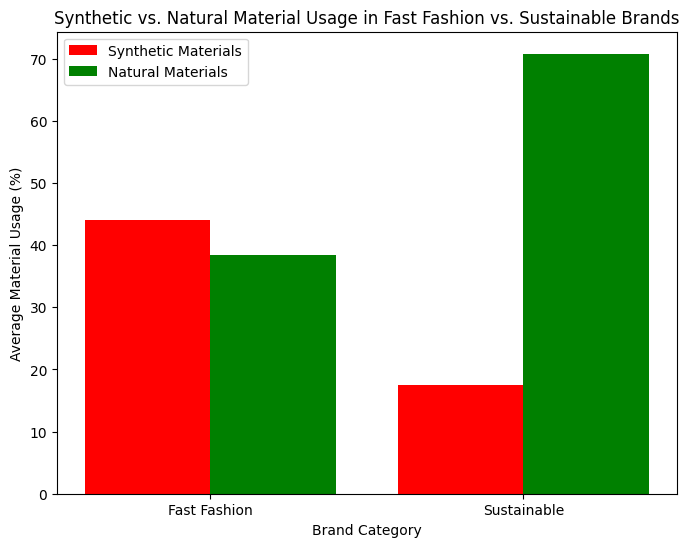

Material Composition Breakdown:


Fast Fashion (Avg Synthetic %)  Fast Fashion (Avg Natural %)  \
Material Usage                       44.022989                     38.477011   

                Sustainable (Avg Synthetic %)  Sustainable (Avg Natural %)  
Material Usage                           17.5                    70.833333

In [77]:
# Load datasets
fast_fashion_df = pd.read_csv("fast_fashion_data.csv")
sustainable_df = pd.read_csv("sustainable_data.csv")

# Define synthetic and natural materials categories
synthetic_materials = ["polyester", "acrylic", "polyamide", "elastane", "nylon", "viscose", "spandex", "rayon"]
natural_materials = ["cotton", "organic cotton", "wool", "linen", "hemp", "silk", "bamboo", "regenerative cotton"]

# Function to categorize materials and calculate percentages
def categorize_materials(df, column_name="Material Composition"):
    df["Synthetic %"] = 0
    df["Natural %"] = 0

    for index, row in df.iterrows():
        synthetic_count = 0
        natural_count = 0
        total_count = 0

        # Ensure the column exists and is not null
        if column_name in df.columns and pd.notna(row[column_name]):
            materials = row[column_name].split(",")
        else:
            materials = []

        # Categorize materials
        for material in materials:
            material = material.strip().lower()
            total_count += 1
            if any(syn in material for syn in synthetic_materials):
                synthetic_count += 1
            if any(nat in material for nat in natural_materials):
                natural_count += 1

        # Calculate percentage of each category
        if total_count > 0:
            df.at[index, "Synthetic %"] = (synthetic_count / total_count) * 100
            df.at[index, "Natural %"] = (natural_count / total_count) * 100

    return df

# Apply categorization to both datasets
fast_fashion_df = categorize_materials(fast_fashion_df)
sustainable_df = categorize_materials(sustainable_df)

# Compute average synthetic vs. natural material usage
material_breakdown = {
    "Fast Fashion (Avg Synthetic %)": np.mean(fast_fashion_df["Synthetic %"]),
    "Fast Fashion (Avg Natural %)": np.mean(fast_fashion_df["Natural %"]),
    "Sustainable (Avg Synthetic %)": np.mean(sustainable_df["Synthetic %"]),
    "Sustainable (Avg Natural %)": np.mean(sustainable_df["Natural %"]),
}

# Convert to DataFrame for visualization
material_breakdown_df = pd.DataFrame(material_breakdown, index=["Material Usage"])

# Visualization - Bar chart comparing synthetic vs. natural materials
categories = ["Fast Fashion", "Sustainable"]
synthetic_usage = [material_breakdown["Fast Fashion (Avg Synthetic %)"], material_breakdown["Sustainable (Avg Synthetic %)"]]
natural_usage = [material_breakdown["Fast Fashion (Avg Natural %)"], material_breakdown["Sustainable (Avg Natural %)"]]

plt.figure(figsize=(8, 6))
bar_width = 0.4
index = np.arange(len(categories))

plt.bar(index, synthetic_usage, bar_width, label="Synthetic Materials", color="red")
plt.bar(index + bar_width, natural_usage, bar_width, label="Natural Materials", color="green")

plt.xlabel("Brand Category")
plt.ylabel("Average Material Usage (%)")
plt.title("Synthetic vs. Natural Material Usage in Fast Fashion vs. Sustainable Brands")
plt.xticks(index + bar_width / 2, categories)
plt.legend()

# Show the plot
plt.show()

# Save the material analysis to CSV
material_breakdown_df.to_csv("material_composition_comparison.csv", index=False)

# Print results
print("Material Composition Breakdown:")
material_breakdown_df


In [78]:
# Load datasets
fast_fashion_df = pd.read_csv("fast_fashion_data.csv")
sustainable_df = pd.read_csv("sustainable_data.csv")

# Define individual material categories
materials_list = ["polyester", "acrylic", "polyamide", "elastane", "nylon", "viscose", "spandex", "rayon",
                  "cotton", "organic cotton", "wool", "linen", "hemp", "silk", "bamboo", "regenerative cotton"]

# Function to categorize materials and calculate frequencies
def extract_material_frequencies(df, column_name="Material Composition"):
    material_counts = {material: 0 for material in materials_list}

    for materials in df[column_name].dropna():
        material_list = [m.strip().lower() for m in materials.split(",")]
        for material in material_list:
            for key in material_counts.keys():
                if key in material:
                    material_counts[key] += 1

    return material_counts

# Extract material frequencies for both fast fashion and sustainable brands
fast_fashion_material_counts = extract_material_frequencies(fast_fashion_df)
sustainable_material_counts = extract_material_frequencies(sustainable_df)

# Convert material data to DataFrame for visualization
material_comparison_df = pd.DataFrame({
    "Material": materials_list,
    "Fast Fashion Usage": [fast_fashion_material_counts[mat] for mat in materials_list],
    "Sustainable Usage": [sustainable_material_counts[mat] for mat in materials_list]
})

# Sort materials by fast fashion usage for better visualization
material_comparison_df = material_comparison_df.sort_values(by="Fast Fashion Usage", ascending=False)

# Save the material breakdown comparison to CSV
material_comparison_df.to_csv("material_breakdown_by_type.csv", index=False)

# Print results
print("Material Breakdown by Individual Type:")
material_comparison_df


Material Breakdown by Individual Type:


Material  Fast Fashion Usage  Sustainable Usage
0             polyester                  38                  6
8                cotton                  29                 50
5               viscose                  21                  0
3              elastane                   8                 13
2             polyamide                   8                  0
9        organic cotton                   4                 12
4                 nylon                   2                  0
10                 wool                   2                  0
13                 silk                   1                  0
7                 rayon                   0                  0
1               acrylic                   0                  0
6               spandex                   0                  0
11                linen                   0                  1
12                 hemp                   0                  0
14               bamboo                   0                  0
15  regenerative cotton                   0                 13

In [79]:
# Function to detect greenwashing claims
def detect_greenwashing(df, column_name="Material Composition"):
    greenwashing_terms = ["recycled polyester", "eco-friendly", "sustainable", "organic blend", "responsible"]
    synthetic_keywords = ["polyester", "nylon", "acrylic", "elastane", "viscose"]
    
    greenwashing_cases = []
    
    for index, row in df.iterrows():
        if pd.notna(row[column_name]):
            material_text = row[column_name].lower()
            
            # Check if greenwashing terms appear but the material is still synthetic
            if any(term in material_text for term in greenwashing_terms):
                if any(syn in material_text for syn in synthetic_keywords):
                    greenwashing_cases.append({
                        "Product Name": row["Product Name"],
                        "Brand": row["Brand Name"],
                        "Material Composition": row[column_name],
                        "Price": row["Price"],
                        "Greenwashing Indicator": "Sustainable claim with synthetic materials"
                    })

    return pd.DataFrame(greenwashing_cases)

# Apply greenwashing detection on fast fashion dataset
greenwashing_df = detect_greenwashing(fast_fashion_df)

# Save to CSV
greenwashing_df.to_csv("greenwashing_report.csv", index=False)

# Print results
print("Potential Greenwashing Cases Detected:")
greenwashing_df


Potential Greenwashing Cases Detected:


Product Name      Brand  \
0                 Lala Floral Maxi Dress  ALLSAINTS   
1  Sofi Drawstring Leather Bomber Jacket  ALLSAINTS   
2            Lizi Tiered Lace Maxi Skirt  ALLSAINTS   
3                 Bryony Maxi Slip Dress  ALLSAINTS   
4          Averie Ten Relaxed Fit Blazer  ALLSAINTS   

                                Material Composition  Price  \
0  95% polyester, 5% elastane, 100% recycled poly...  299.0   
1  100% sheep leather Rib, 97% organic cotton, 3%...  399.0   
2                            100% recycled polyester  199.0   
3                            100% recycled polyester  129.0   
4  100% TENCEL, 100% recycled polyester TENCEL, 8...  289.0   

                       Greenwashing Indicator  
0  Sustainable claim with synthetic materials  
1  Sustainable claim with synthetic materials  
2  Sustainable claim with synthetic materials  
3  Sustainable claim with synthetic materials  
4  Sustainable claim with synthetic materials

In [80]:
# Load datasets
fast_fashion_df = pd.read_csv("fast_fashion_data.csv")
sustainable_df = pd.read_csv("sustainable_data.csv")

# Define estimated durability (number of wears) for different product categories
durability_factors = {
    "fast_fashion": 30,  # Fast fashion lasts around 30 wears
    "sustainable": 100   # Sustainable products last around 100 wears
}

# Calculate average price for both categories
fast_fashion_avg_price = np.mean(fast_fashion_df["Price"])
sustainable_avg_price = np.mean(sustainable_df["Price"])

# Calculate cost-per-wear for both categories
fast_fashion_cost_per_wear = fast_fashion_avg_price / durability_factors["fast_fashion"]
sustainable_cost_per_wear = sustainable_avg_price / durability_factors["sustainable"]

# Create a summary DataFrame
price_quality_summary = pd.DataFrame({
    "Category": ["Fast Fashion", "Sustainable"],
    "Average Price": [fast_fashion_avg_price, sustainable_avg_price],
    "Estimated Durability (Wears)": [durability_factors["fast_fashion"], durability_factors["sustainable"]],
    "Cost per Wear": [fast_fashion_cost_per_wear, sustainable_cost_per_wear]
})

# Print results in DataFrame format
print("\n--- Price vs. Quality Summary ---\n")
price_quality_summary




--- Price vs. Quality Summary ---



Category  Average Price  Estimated Durability (Wears)  Cost per Wear
0  Fast Fashion      73.677931                            30       2.455931
1   Sustainable    2427.691667                           100      24.276917

In [81]:
SUS = pd.read_csv('FinalData.csv')

In [82]:
SUS = SUS.drop('Rating', axis=1)
SUS.rename(columns={'rating_encoded': 'sustainability_score'}, inplace=True)
SUS

Brand Name         Country               Category  Price Level ($)  \
0      Boll & Branch   United States              Sleepwear                3   
1      Outland Denim       Australia                  Denim                2   
2     STANLEY/STELLA         Belgium  Hoodies & Sweatshirts                1   
3        Yes Friends  United Kingdom               T-Shirts                1   
4              ÉTICA   United States                  Denim                2   
..               ...             ...                    ...              ...   
495       Rirandture           Japan         Tops & Blouses                2   
496       Valleygirl       Australia                Dresses                1   
497           A.P.C.          France                 Shirts                3   
498  BLACK BY MOUSSY           Japan         Tops & Blouses                2   
499           Baleaf   United States                  Pants                2   

     sustainability_score  
0                     5.0  
1                     5.0  
2                     5.0  
3                     5.0  
4                     5.0  
..                    ...  
495                   1.0  
496                   1.0  
497                   1.0  
498                   1.0  
499                   1.0  

[500 rows x 5 columns]

In [83]:
SUS

Brand Name         Country               Category  Price Level ($)  \
0      Boll & Branch   United States              Sleepwear                3   
1      Outland Denim       Australia                  Denim                2   
2     STANLEY/STELLA         Belgium  Hoodies & Sweatshirts                1   
3        Yes Friends  United Kingdom               T-Shirts                1   
4              ÉTICA   United States                  Denim                2   
..               ...             ...                    ...              ...   
495       Rirandture           Japan         Tops & Blouses                2   
496       Valleygirl       Australia                Dresses                1   
497           A.P.C.          France                 Shirts                3   
498  BLACK BY MOUSSY           Japan         Tops & Blouses                2   
499           Baleaf   United States                  Pants                2   

     sustainability_score  
0                     5.0  
1                     5.0  
2                     5.0  
3                     5.0  
4                     5.0  
..                    ...  
495                   1.0  
496                   1.0  
497                   1.0  
498                   1.0  
499                   1.0  

[500 rows x 5 columns]

In [84]:

# 1) Define brand type based on sustainability score threshold
SUS['brand_type'] = SUS['sustainability_score'].apply(
    lambda x: 'Sustainable' if x >= 3 else 'Fast Fashion'
)

# 2) Compare average price per product category
avg_price_by_category = (
    SUS
    .groupby(['brand_type'])['Price Level ($)']
    .mean()
    .reset_index(name='avg_price')
)

print("Average Price by Category (Sustainable vs. Fast Fashion):")
print(avg_price_by_category)


Average Price by Category (Sustainable vs. Fast Fashion):
     brand_type  avg_price
0  Fast Fashion      2.455
1   Sustainable      2.340


##Top 10 Value Rated Brands Providing Sustainbility and Affordability

In [85]:
# 1) Create a 'Value Score' column for SUS
SUS['value_score'] = SUS['sustainability_score'] / SUS['Price Level ($)']

# 2) Aggregate the value score by brand (you could also do it by product level if you prefer)
brand_value_score = (
    SUS
    .groupby('Brand Name')['value_score']
    .mean()
    .reset_index()
    .sort_values(by='value_score', ascending=False)
)

print("Brands Ranked by Value Score (Sustainability / Price Level):")
print(brand_value_score.head(10))  # Show top 10 as an example


Brands Ranked by Value Score (Sustainability / Price Level):
             Brand Name  value_score
471         Yes Friends          5.0
319        Quazi Design          5.0
369           SilkGenie          5.0
354      STANLEY/STELLA          5.0
132         Glass Onion          5.0
253  Mighty Good Basics          5.0
154        INTOA design          5.0
210       Lola & Stella          5.0
168               Joyya          5.0
149       Honest Basics          4.0


C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\1167271887.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




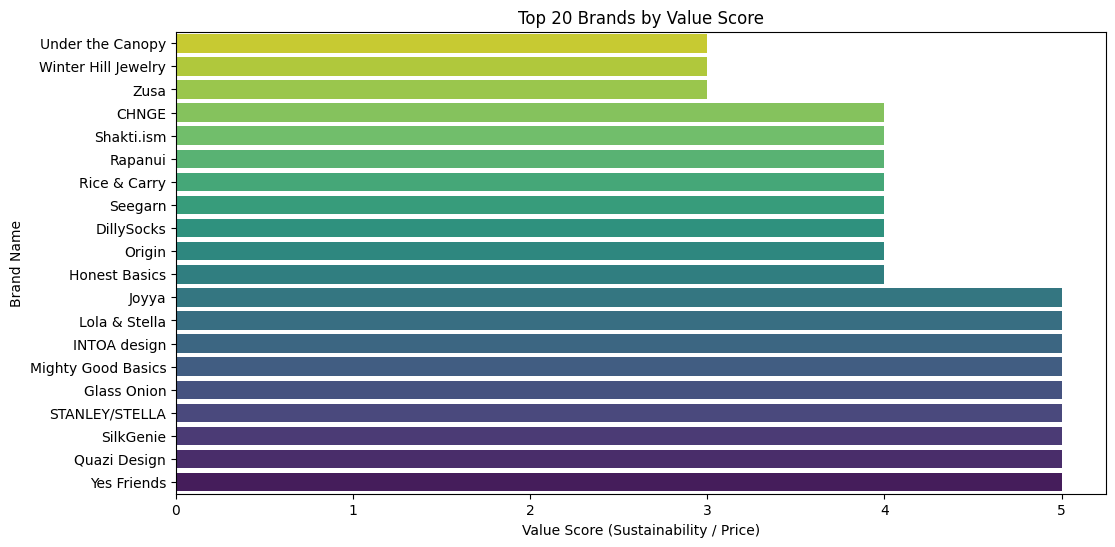

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 product names based on value_score
top_10_products = SUS[['Brand Name', 'value_score']].groupby('Brand Name').mean().reset_index()
top_10_products = top_10_products.sort_values(by='value_score', ascending=False).head(20)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='value_score', y='Brand Name', data=top_10_products, palette='viridis')

# Labels and title
plt.xlabel("Value Score (Sustainability / Price)")
plt.ylabel("Brand Name")
plt.title("Top 20 Brands by Value Score")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization

# Show the plot
plt.show()


In [87]:
SUS

Brand Name         Country               Category  Price Level ($)  \
0      Boll & Branch   United States              Sleepwear                3   
1      Outland Denim       Australia                  Denim                2   
2     STANLEY/STELLA         Belgium  Hoodies & Sweatshirts                1   
3        Yes Friends  United Kingdom               T-Shirts                1   
4              ÉTICA   United States                  Denim                2   
..               ...             ...                    ...              ...   
495       Rirandture           Japan         Tops & Blouses                2   
496       Valleygirl       Australia                Dresses                1   
497           A.P.C.          France                 Shirts                3   
498  BLACK BY MOUSSY           Japan         Tops & Blouses                2   
499           Baleaf   United States                  Pants                2   

     sustainability_score    brand_type  value_score  
0                     5.0   Sustainable     1.666667  
1                     5.0   Sustainable     2.500000  
2                     5.0   Sustainable     5.000000  
3                     5.0   Sustainable     5.000000  
4                     5.0   Sustainable     2.500000  
..                    ...           ...          ...  
495                   1.0  Fast Fashion     0.500000  
496                   1.0  Fast Fashion     1.000000  
497                   1.0  Fast Fashion     0.333333  
498                   1.0  Fast Fashion     0.500000  
499                   1.0  Fast Fashion     0.500000  

[500 rows x 7 columns]

##Which Countries Have the Highest and Lowest Value-Rated Sustainable Brands?

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\1909817160.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




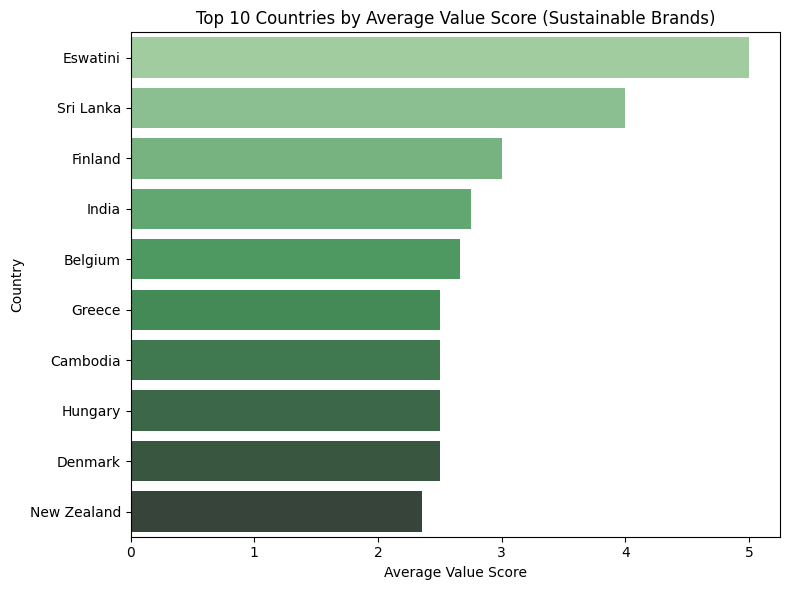

C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\1909817160.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




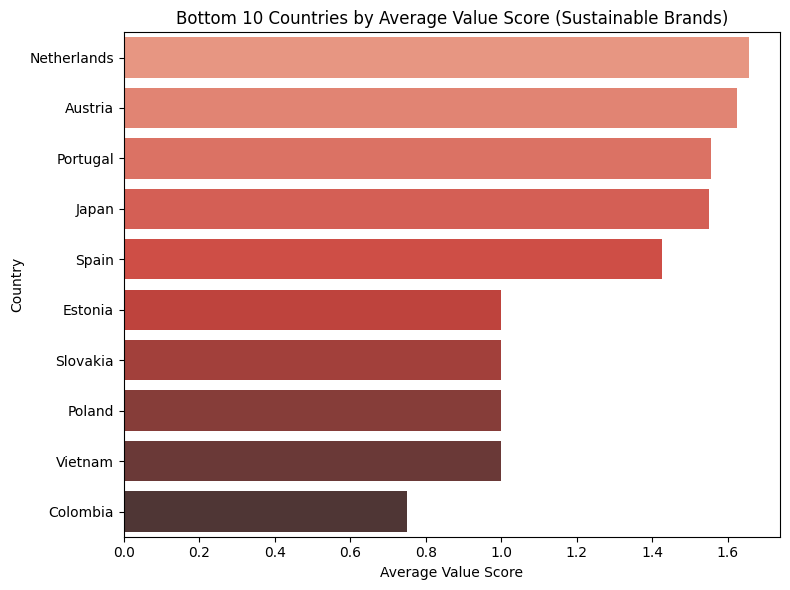

In [88]:
# 1) Filter to keep only sustainable brands
sustainable_df = SUS[SUS['brand_type'] == 'Sustainable']

# 2) Calculate average value_score by country
country_value_scores = (
    sustainable_df
    .groupby('Country')['value_score']
    .mean()
    .sort_values(ascending=False)
)

# 3) Identify top and bottom countries
top_countries = country_value_scores.head(10)
bottom_countries = country_value_scores.tail(10)

# print("Top Countries by Value Score (Sustainable Brands):")
# print(top_countries)

# print("\nBottom Countries by Value Score (Sustainable Brands):")
# print(bottom_countries)

# 4) Visualization

# -- Top 10 Countries --
plt.figure(figsize=(8, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='Greens_d')
plt.title("Top 10 Countries by Average Value Score (Sustainable Brands)")
plt.xlabel("Average Value Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# -- Bottom 10 Countries --
plt.figure(figsize=(8, 6))
sns.barplot(x=bottom_countries.values, y=bottom_countries.index, palette='Reds_d')
plt.title("Bottom 10 Countries by Average Value Score (Sustainable Brands)")
plt.xlabel("Average Value Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


##How Do Sustainable Brands Compare to Fast-Fashion Brands on Price?

Average Price Level by Brand Type:
     brand_type  avg_price_level
0  Fast Fashion            2.455
1   Sustainable            2.340


C:\Users\Tithi\AppData\Local\Temp\ipykernel_18520\1088753125.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




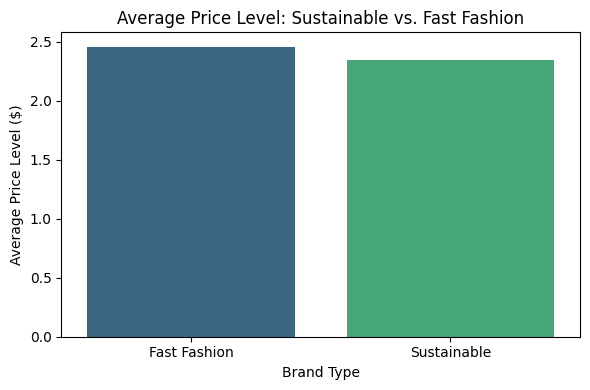

T-test: t-statistic = -1.55, p-value = 0.1231
=> No statistically significant difference in price levels.


In [89]:
from scipy.stats import ttest_ind

# 1) Group by brand_type and compute the mean Price Level
avg_price = (
    SUS
    .groupby('brand_type')['Price Level ($)']
    .mean()
    .reset_index(name='avg_price_level')
)

print("Average Price Level by Brand Type:")
print(avg_price)

# 2) Visualization: Bar chart comparing average Price Level for Sustainable vs. Fast Fashion
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_price, x='brand_type', y='avg_price_level', palette='viridis')
plt.title("Average Price Level: Sustainable vs. Fast Fashion")
plt.xlabel("Brand Type")
plt.ylabel("Average Price Level ($)")
plt.tight_layout()
plt.show()

# 3) (Optional) Statistical Test: Compare price levels between Sustainable and Fast Fashion
sustainable_prices = SUS.loc[SUS['brand_type'] == 'Sustainable', 'Price Level ($)']
fast_fashion_prices = SUS.loc[SUS['brand_type'] == 'Fast Fashion', 'Price Level ($)']

# Check that both groups have data
if len(sustainable_prices) > 1 and len(fast_fashion_prices) > 1:
    t_stat, p_value = ttest_ind(sustainable_prices, fast_fashion_prices, equal_var=False)
    print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("=> There is a statistically significant difference in price levels.")
    else:
        print("=> No statistically significant difference in price levels.")
else:
    print("Not enough data to perform a statistical test.")
